In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sklearn as sk
from sklearn.decomposition import NMF
import os

import PlaceCellAnalysis as pc
import utilities as u
import preprocessing as pp
import behavior as b
import BayesianDecoding as bd
import ensemble as nmf


os.sys.path.append("")

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [20]:
# load database
df = pp.load_session_db()
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
mouse = '4139265.3'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_noTimeout') | df_mouse['Track'].str.match('TwoTower_Timeout')|
                   df_mouse['Track'].str.match('TwoTower_foraging')]


G:\My Drive\VR_Data\TwoTower\behavior.sqlite


In [21]:
df_mouse

MouseName  DateFolder  SessionNumber              Track  RewardCount  \
1403  4139265.3  10_02_2019              1  TwoTower_foraging           60   
1405  4139265.3  10_02_2019              3  TwoTower_foraging           60   
1433  4139265.3  12_02_2019              2  TwoTower_foraging           90   
1455  4139265.3  15_02_2019              4  TwoTower_foraging           72   
1475  4139265.3  17_02_2019              2  TwoTower_foraging           81   
1495  4139265.3  19_02_2019              2  TwoTower_foraging           92   
1513  4139265.3  21_02_2019              2  TwoTower_foraging           90   
1522  4139265.3  22_02_2019              2  TwoTower_foraging           90   
1531  4139265.3  23_02_2019              2  TwoTower_foraging           93   
1537  4139265.3  24_02_2019              2  TwoTower_foraging           97   

      Imaging ImagingRegion   DateTime  \
1403        1           CA1 2019-02-10   
1405        1           CA1 2019-02-10   
1433        1           CA1 2019-02-12   
1455        1           CA1 2019-02-15   
1475        1           CA1 2019-02-17   
1495        1           CA1 2019-02-19   
1513        1           CA1 2019-02-21   
1522        1           CA1 2019-02-22   
1531        1           CA1 2019-02-23   
1537        1           CA1 2019-02-24   

                                              data file scanfile  \
1403  G:\My Drive\VR_Data\TwoTower\4139265.3\10_02_2...     None   
1405  G:\My Drive\VR_Data\TwoTower\4139265.3\10_02_2...     None   
1433  G:\My Drive\VR_Data\TwoTower\4139265.3\12_02_2...     None   
1455  G:\My Drive\VR_Data\TwoTower\4139265.3\15_02_2...     None   
1475  G:\My Drive\VR_Data\TwoTower\4139265.3\17_02_2...     None   
1495  G:\My Drive\VR_Data\TwoTower\4139265.3\19_02_2...     None   
1513  G:\My Drive\VR_Data\TwoTower\4139265.3\21_02_2...     None   
1522  G:\My Drive\VR_Data\TwoTower\4139265.3\22_02_2...     None   
1531  G:\My Drive\VR_Data\TwoTower\4139265.3\23_02_2...     None   
1537  G:\My Drive\VR_Data\TwoTower\4139265.3\24_02_2...     None   

                                                scanmat  \
1403  G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...   
1405  G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...   
1433  G:\My Drive\2P_Data\TwoTower\4139265.3\12_02_2...   
1455  G:\My Drive\2P_Data\TwoTower\4139265.3\15_02_2...   
1475  G:\My Drive\2P_Data\TwoTower\4139265.3\17_02_2...   
1495  G:\My Drive\2P_Data\TwoTower\4139265.3\19_02_2...   
1513  G:\My Drive\2P_Data\TwoTower\4139265.3\21_02_2...   
1522  G:\My Drive\2P_Data\TwoTower\4139265.3\22_02_2...   
1531  G:\My Drive\2P_Data\TwoTower\4139265.3\23_02_2...   
1537  G:\My Drive\2P_Data\TwoTower\4139265.3\24_02_2...   

                                              s2pfolder  
1403  G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...  
1405  G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...  
1433  G:\My Drive\2P_Data\TwoTower\4139265.3\12_02_2...  
1455  G:\My Drive\2P_Data\TwoTower\4139265.3\15_02_2...  
1475  G:\My Drive\2P_Data\TwoTower\4139265.3\17_02_2...  
1495  G:\My Drive\2P_Data\TwoTower\4139265.3\19_02_2...  
1513  G:\My Drive\2P_Data\TwoTower\4139265.3\21_02_2...  
1522  G:\My Drive\2P_Data\TwoTower\4139265.3\22_02_2...  
1531  G:\My Drive\2P_Data\TwoTower\4139265.3\23_02_2...  
1537  G:\My Drive\2P_Data\TwoTower\4139265.3\24_02_2...

In [22]:
# pick session
sess = df_mouse.iloc[-1]

In [23]:
# load trial mat
VRDat,C, S, A = pp.load_scan_sess(sess)
print(VRDat.shape,S.shape)
Smean = np.mean(S,axis=0)
S /= Smean[np.newaxis,:]
Ssm = sp.ndimage.filters.gaussian_filter(S,[5,0])
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
S_trial_mat, occ, edges, centers = u.make_pos_bin_trial_matrices(S,VRDat.pos._values,tstart_inds,teleport_inds,bin_size=20)
S_trial_mat = sp.ndimage.filters.gaussian_filter(S_trial_mat,[0,1,0])

num aberrant ttls 0.0
32038 (32038,) (32038, 21) 105022


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0
(32038, 22) (32038, 1634)


In [24]:
# get rate map in two extremes, smooth and subtract them
CD=np.squeeze(np.nanmedian(S_trial_mat[trial_info['morphs']==1,:,:],axis=0)-np.nanmedian(S_trial_mat[trial_info['morphs']==0,:,:],axis=0))
CD/=np.linalg.norm(CD,2,axis=1)[:,np.newaxis]
S_norm = S/(np.linalg.norm(S,2,axis=1)[:,np.newaxis]+.0001)
print(CD.shape)

(23, 1634)


In [25]:
# project data at every time point onto the appropriate vector
pos_binned = np.digitize(VRDat.pos._values,edges)
# ignore first and last inds
inds = pos_binned-1
#mask = (pos_binned>0) & (pos_binned<45)
CDmat = np.zeros(S.shape)
for t in range(S.shape[0]):
    if pos_binned[t]>0 and pos_binned[t]<46:
        CDmat = CD[inds[t],:]


In [26]:
PROJ = np.multiply(S_norm,CDmat).sum(axis=1)

In [27]:
#effMorph = VRDat.morph._values+VRDat.bckgndJitter._values+VRDat

C:\Users\mplitt\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


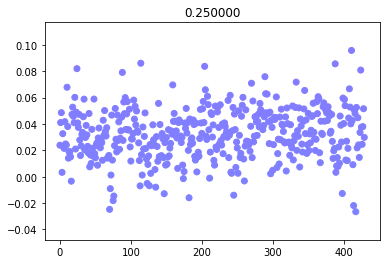

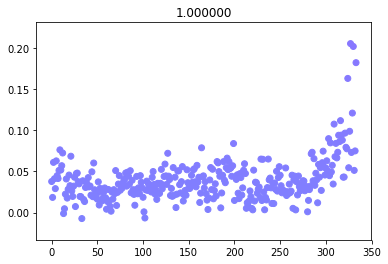

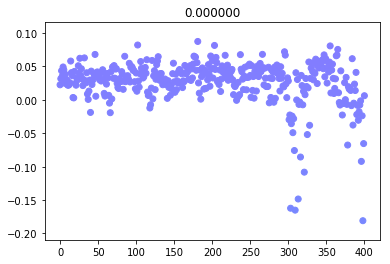

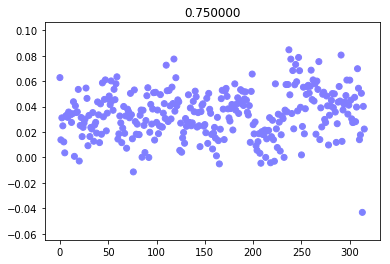

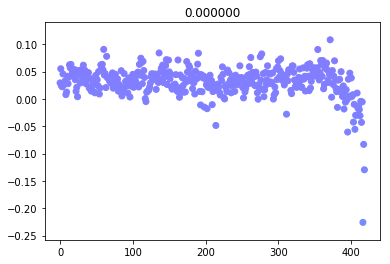

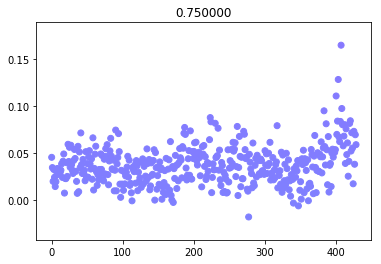

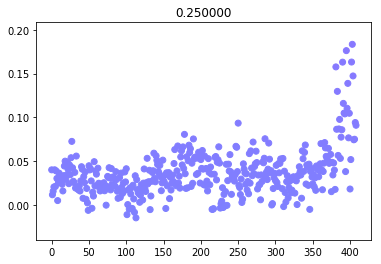

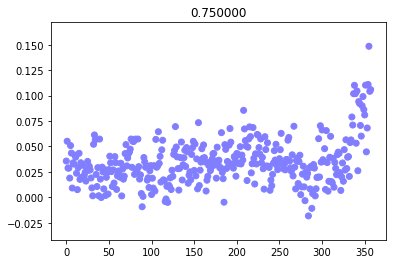

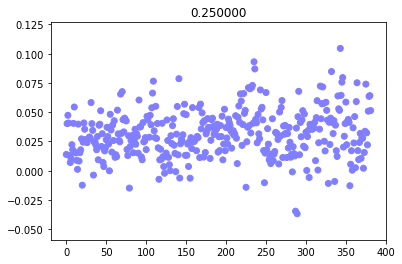

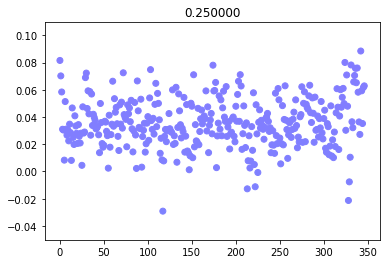

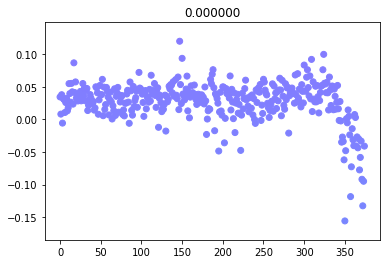

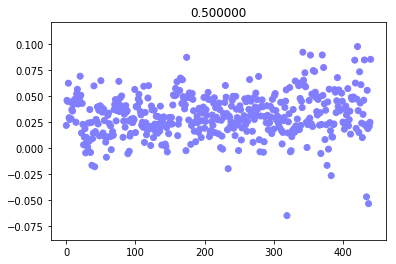

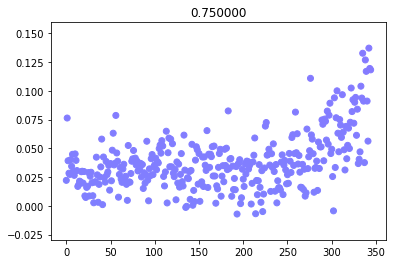

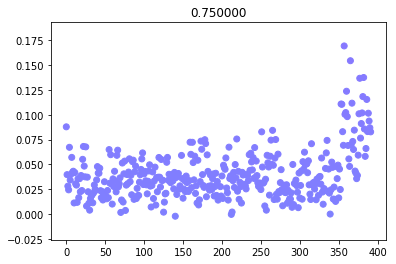

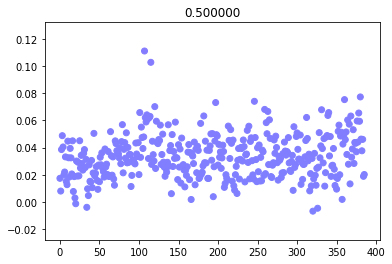

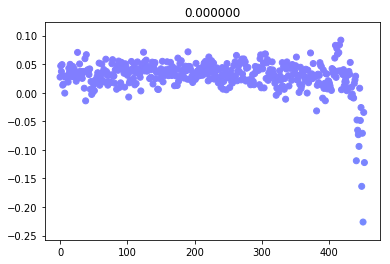

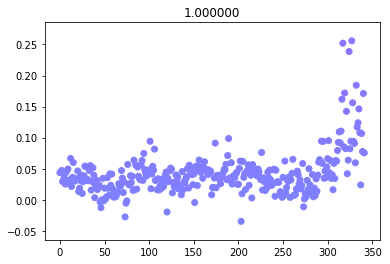

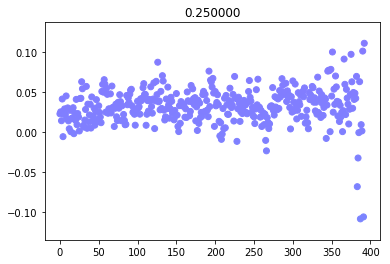

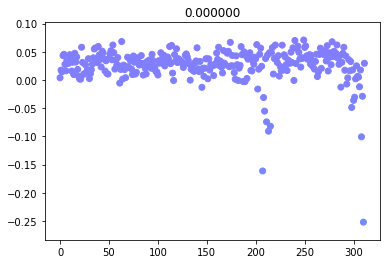

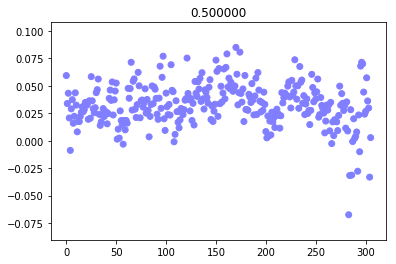

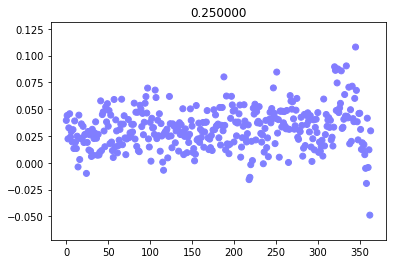

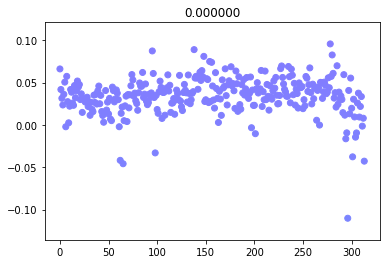

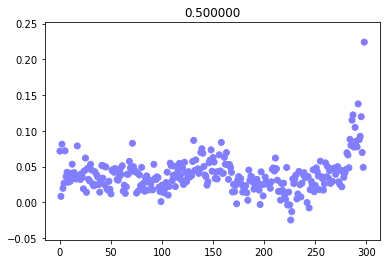

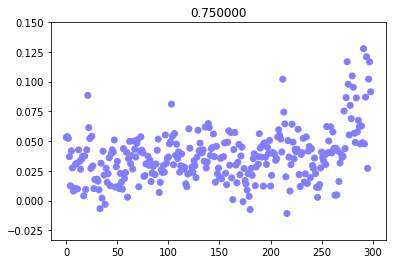

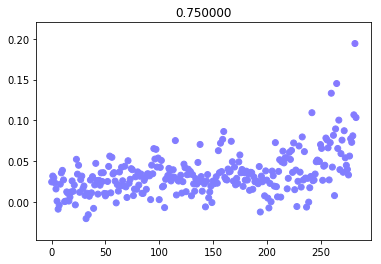

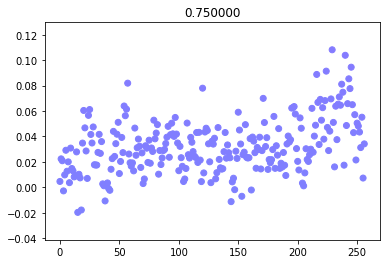

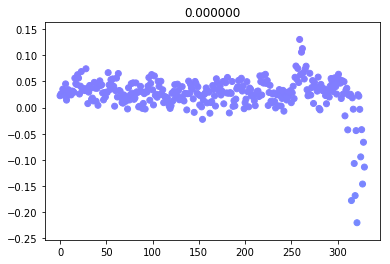

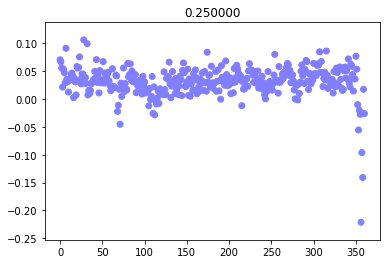

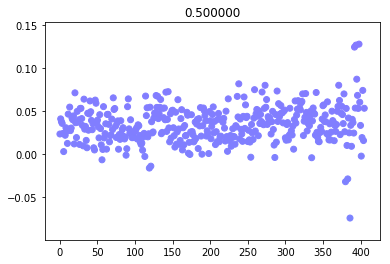

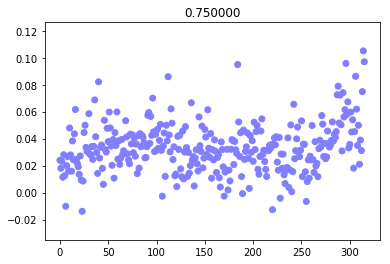

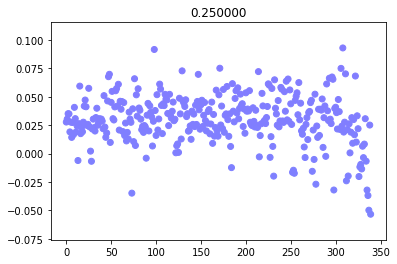

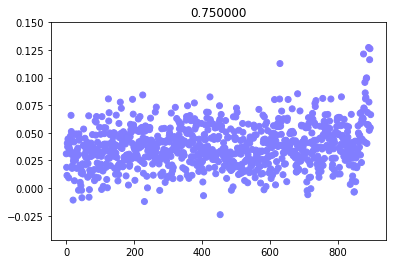

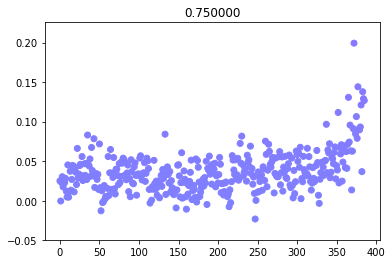

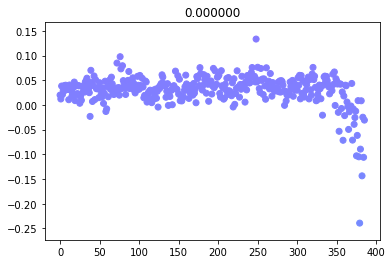

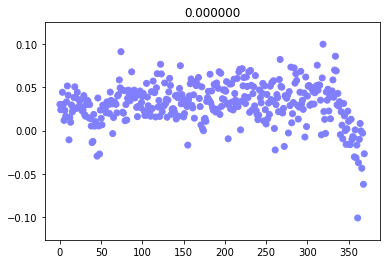

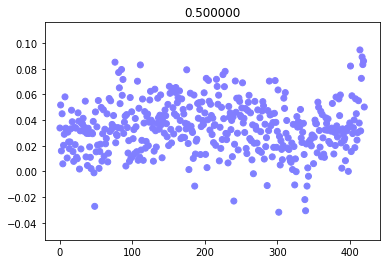

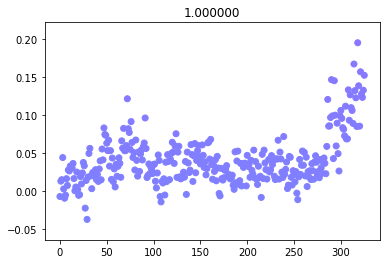

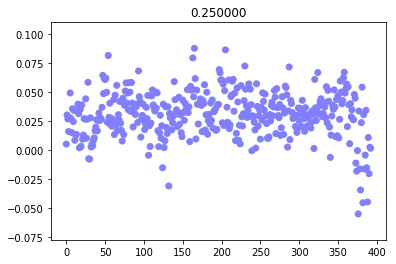

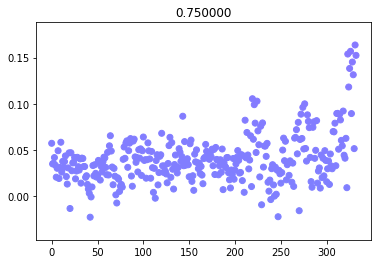

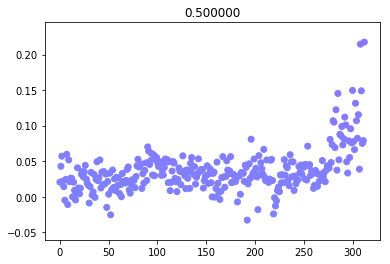

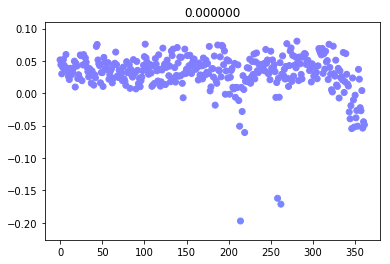

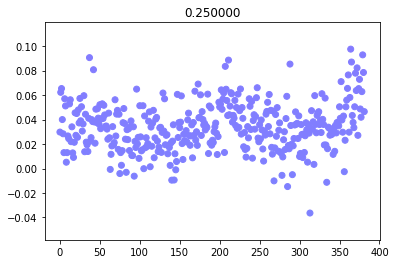

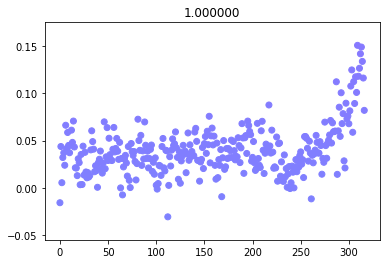

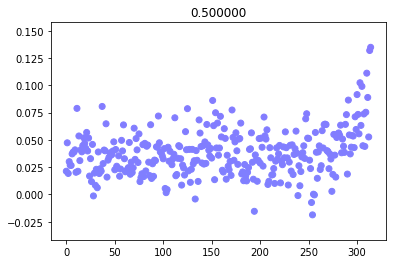

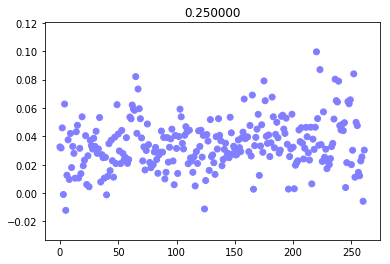

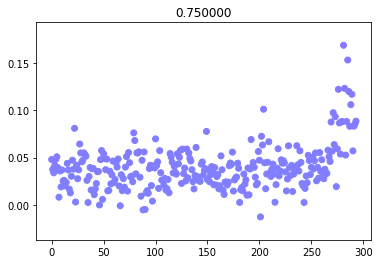

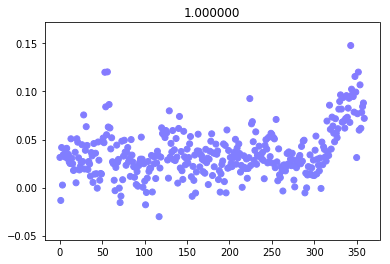

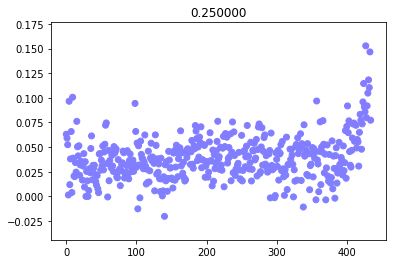

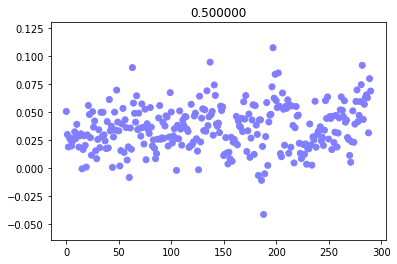

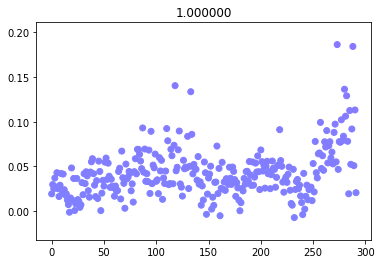

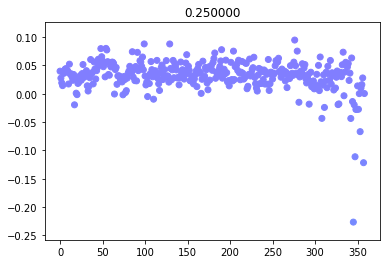

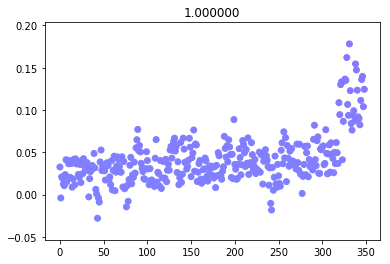

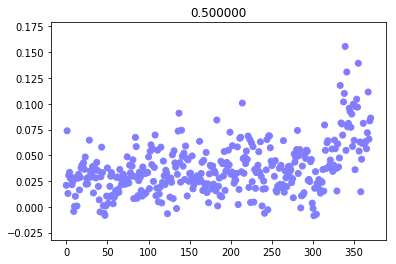

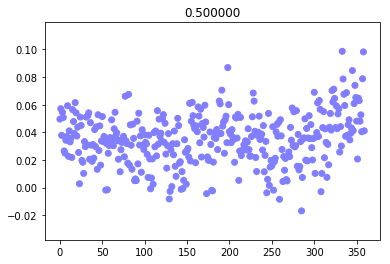

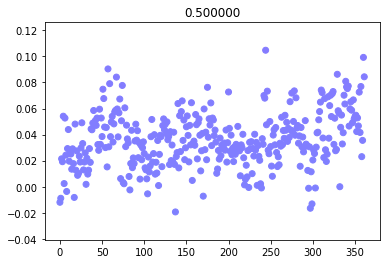

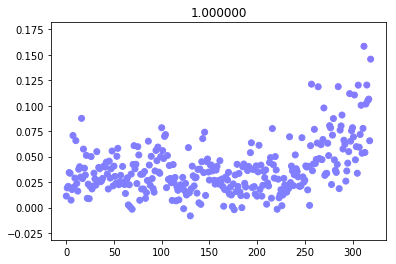

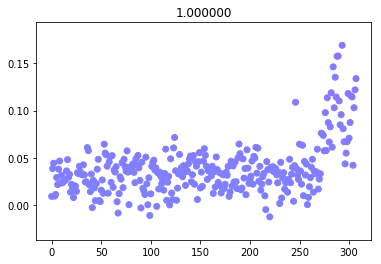

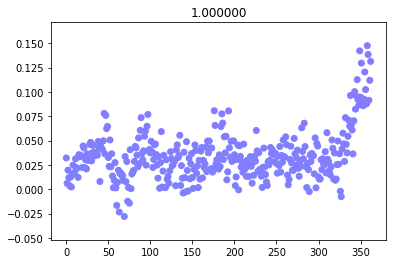

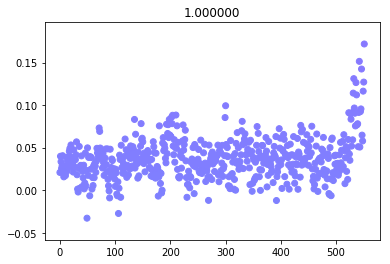

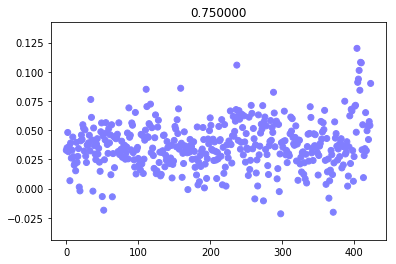

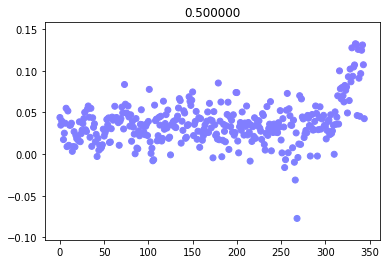

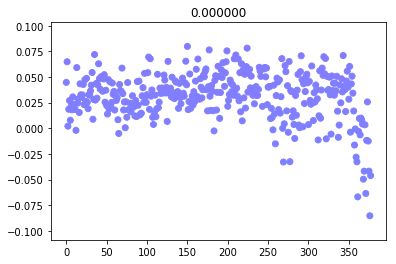

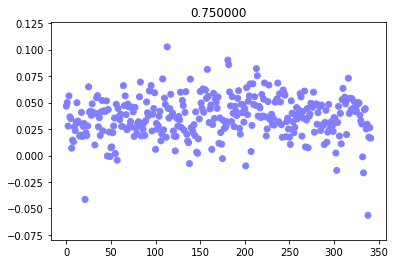

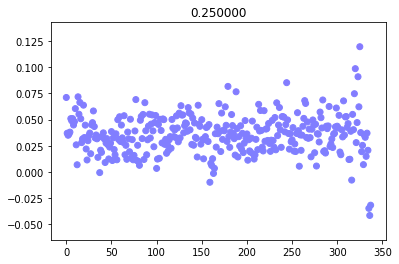

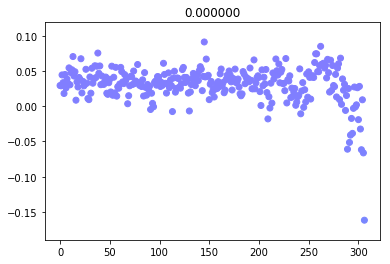

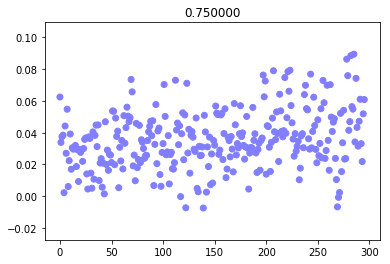

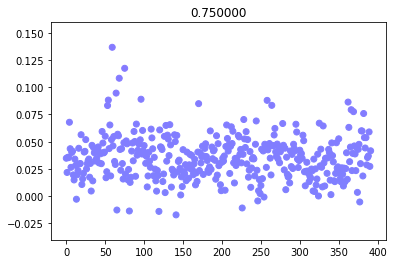

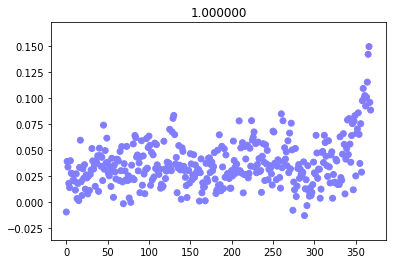

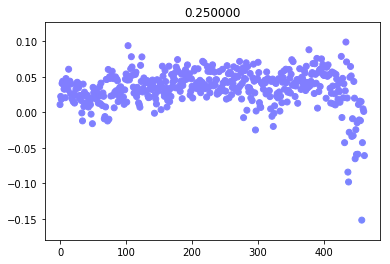

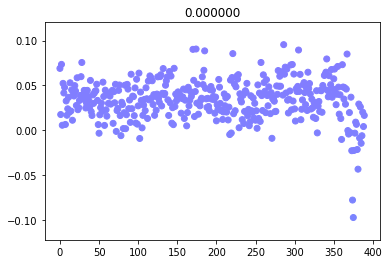

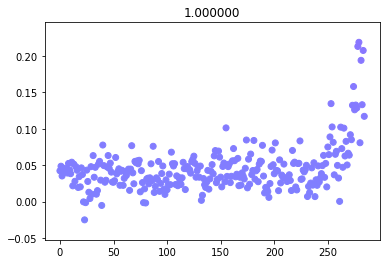

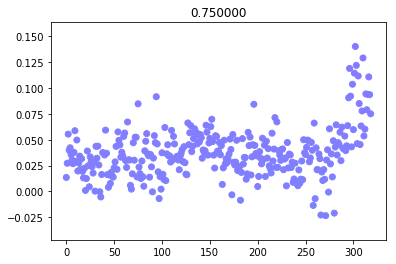

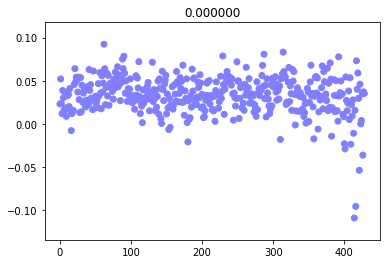

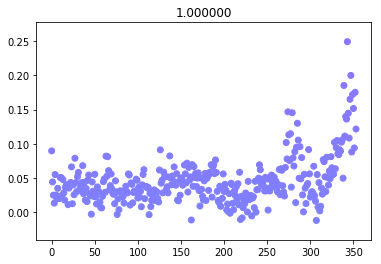

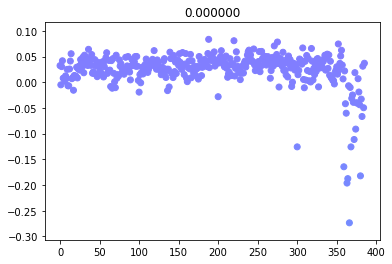

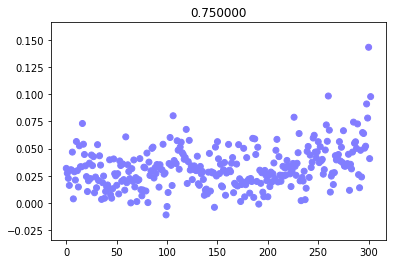

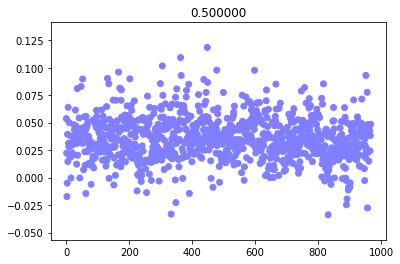

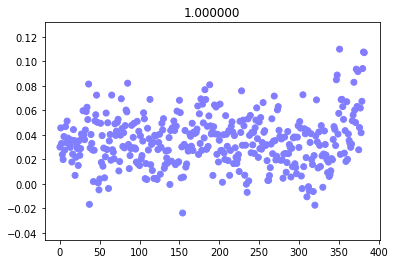

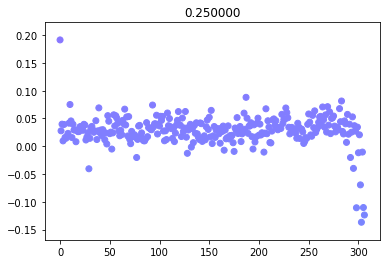

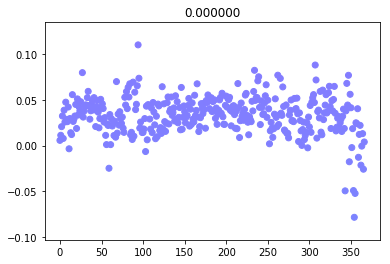

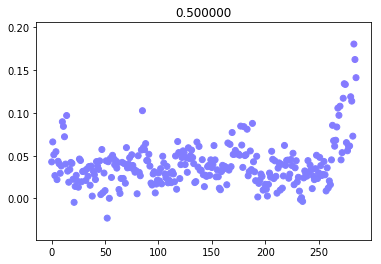

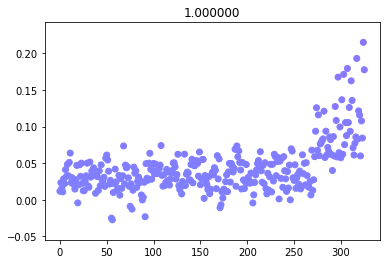

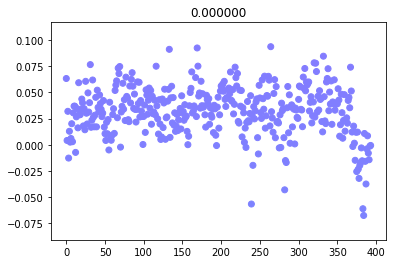

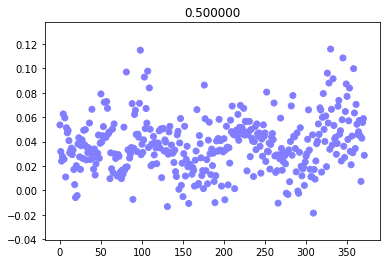

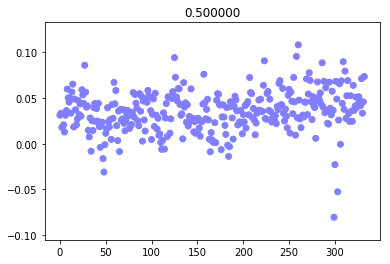

In [11]:
for i,(start,stop) in enumerate(zip(tstart_inds.tolist(),teleport_inds.tolist())):
    f,ax = plt.subplots()
    ax.scatter(np.arange(stop-1-start),PROJ[start:stop-1],c=PROJ[start:stop-1],cmap='cool',vmin=-3,vmax=3)
#     ax.plot(np.arange(stop-1-start),np.cumsum(PROJ[start:stop-1]))
    ax.set_title("%f" % trial_info['morphs'][i])
#     ax.set_ylim([-.5,.5])

In [12]:
print(centers.shape)

(23,)


In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [29]:
mask = ((VRDat.morph._values==0) | (VRDat.morph._values==1.)) & (VRDat.pos._values>0)

In [30]:
lda = LDA()
lda.fit(S[mask,:],VRDat.morph._values[mask])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [31]:
PROJ = lda.predict_proba(Ssm) #transform(S)

C:\Users\mplitt\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


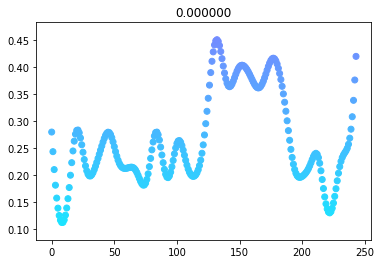

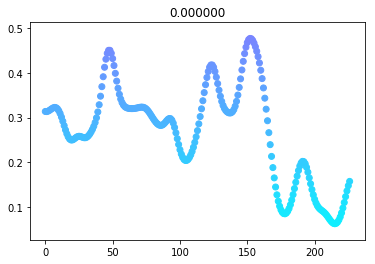

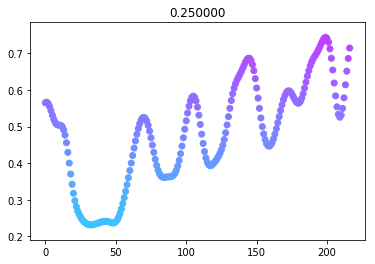

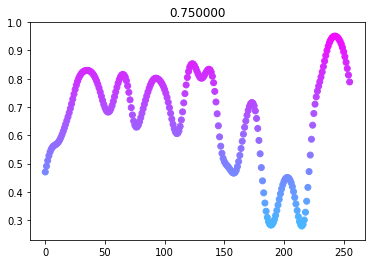

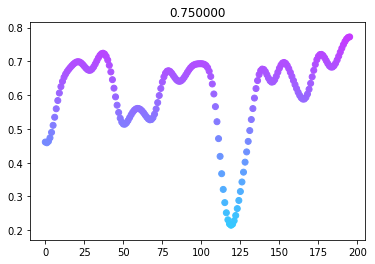

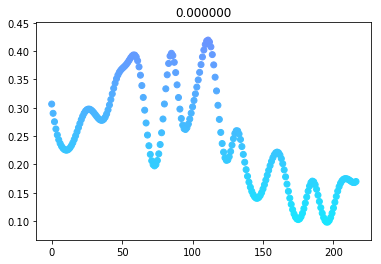

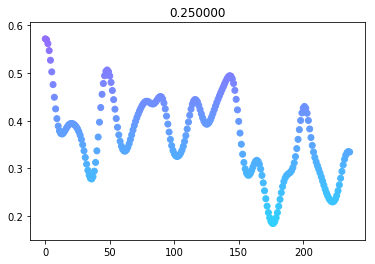

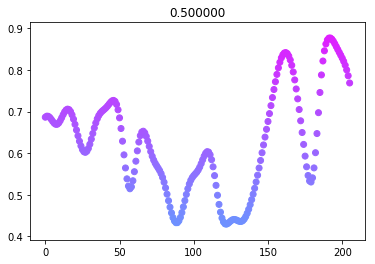

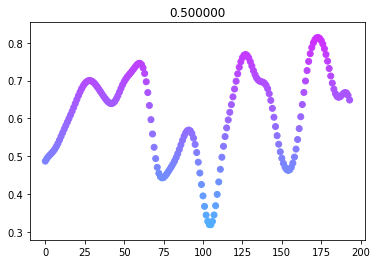

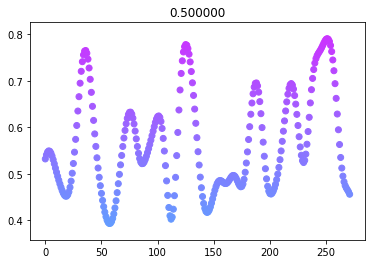

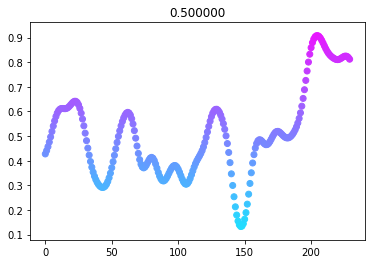

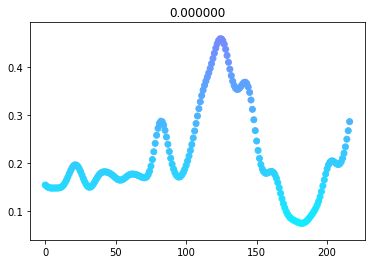

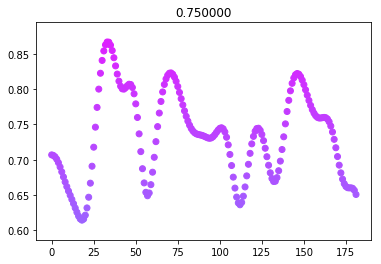

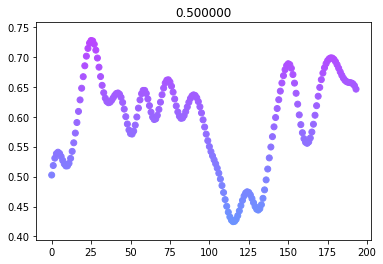

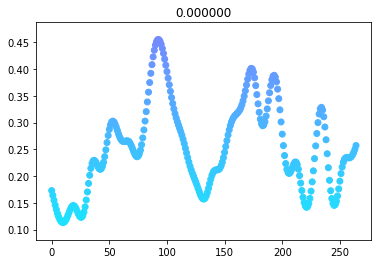

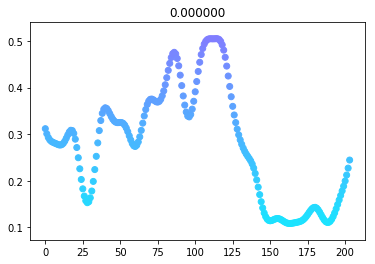

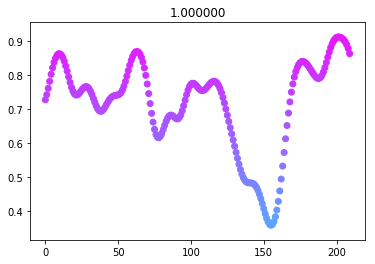

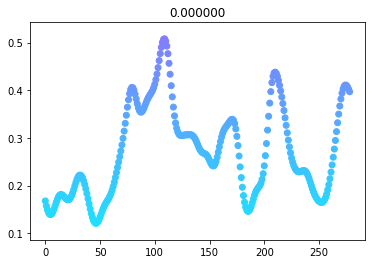

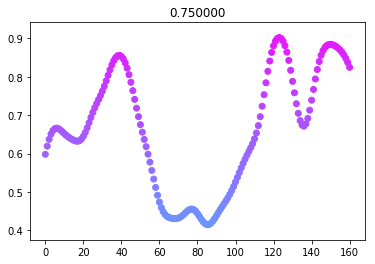

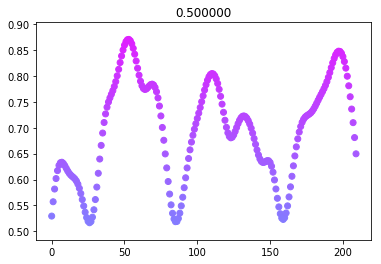

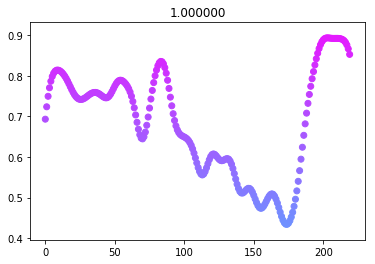

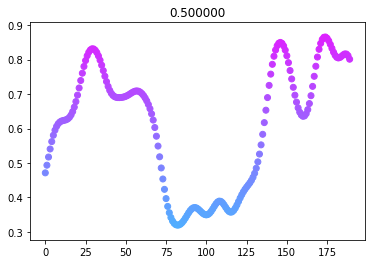

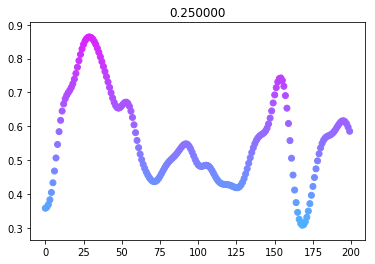

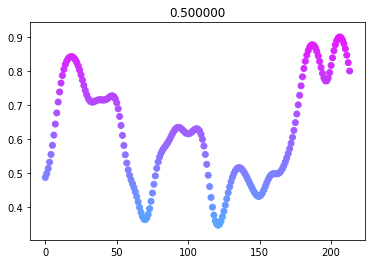

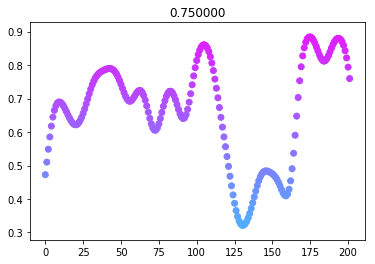

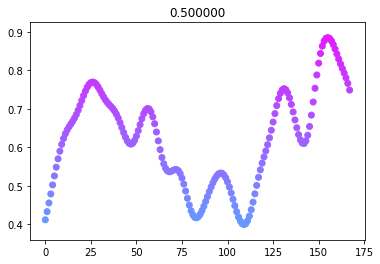

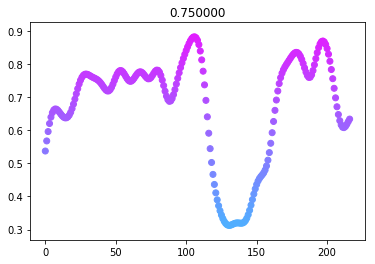

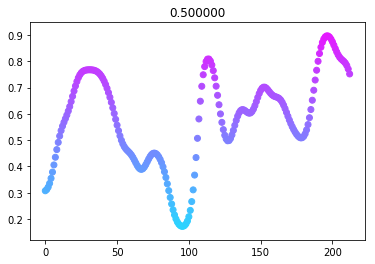

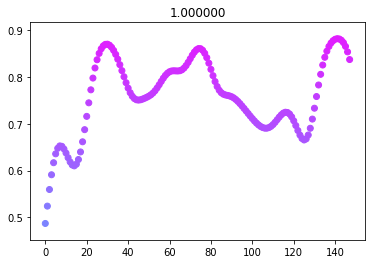

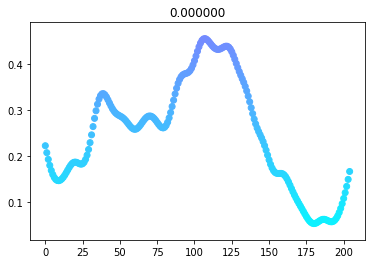

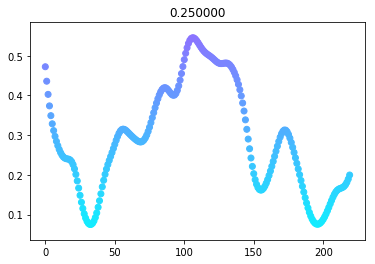

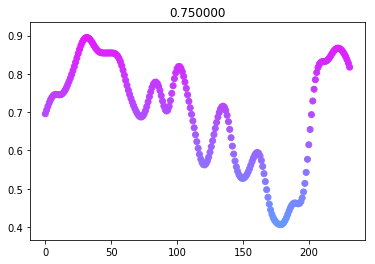

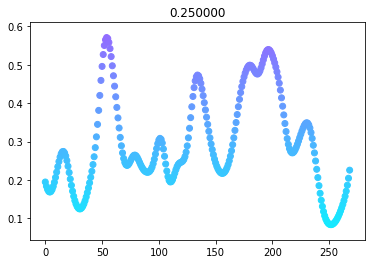

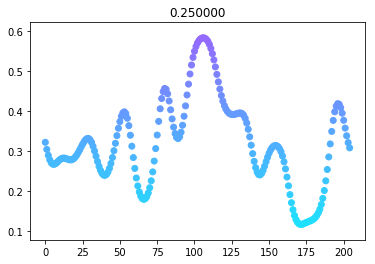

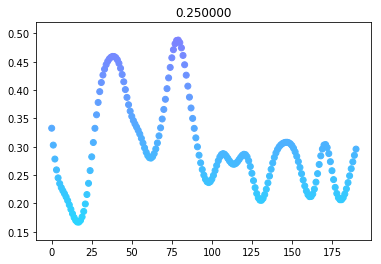

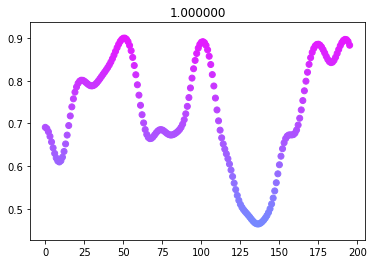

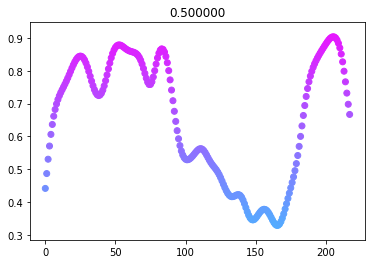

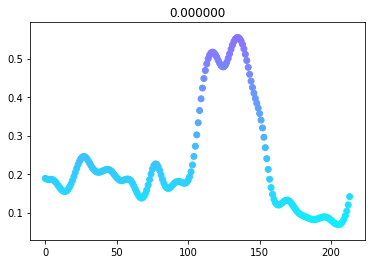

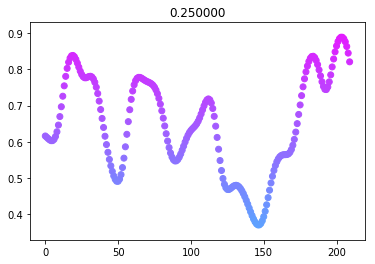

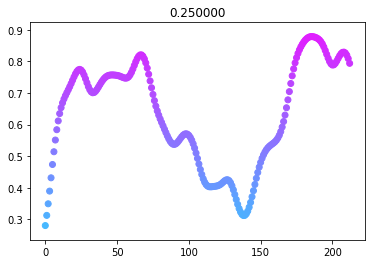

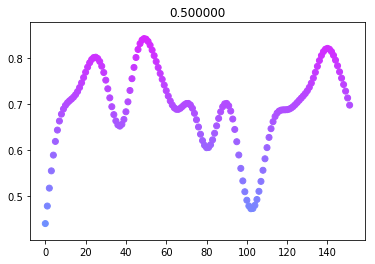

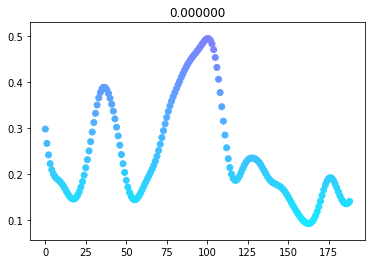

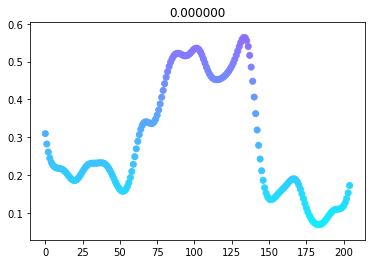

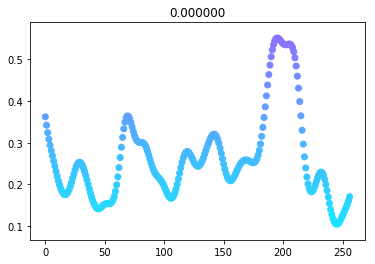

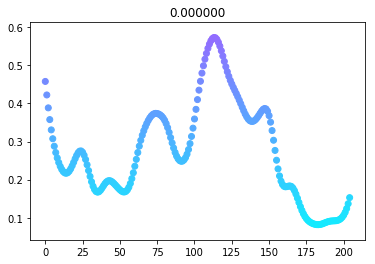

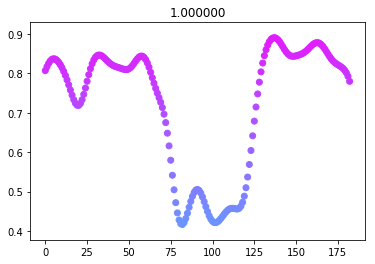

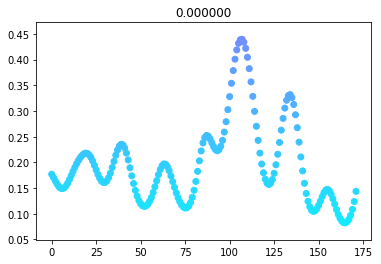

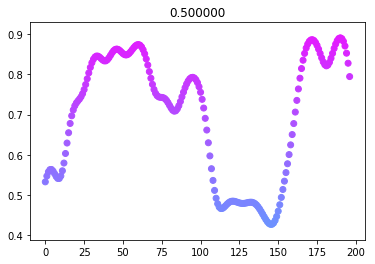

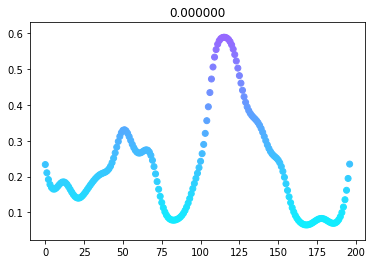

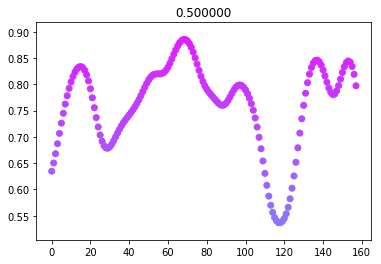

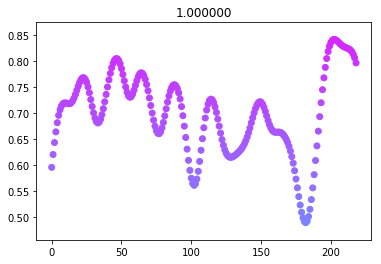

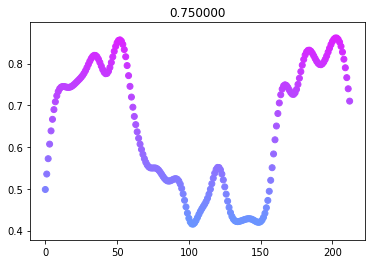

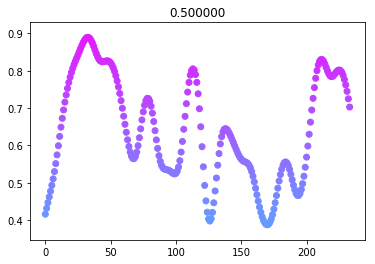

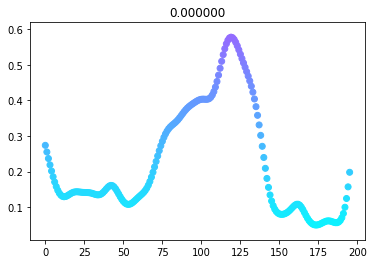

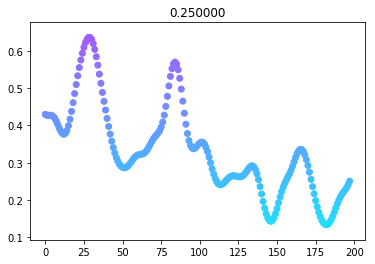

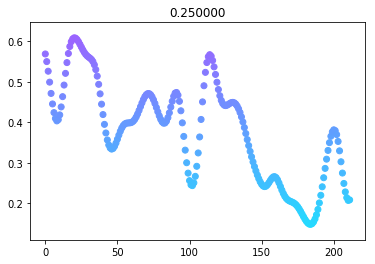

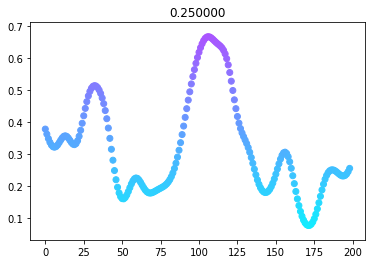

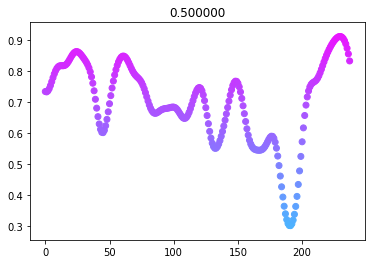

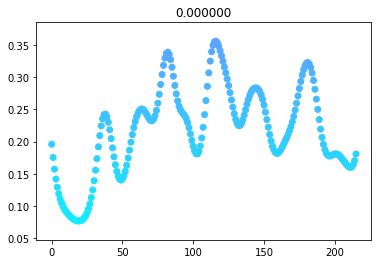

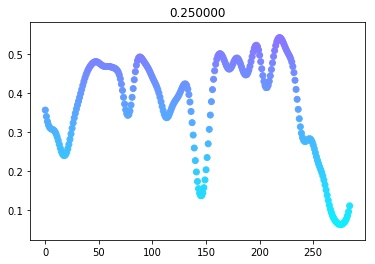

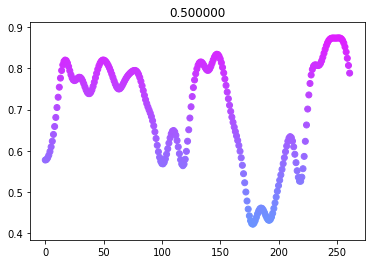

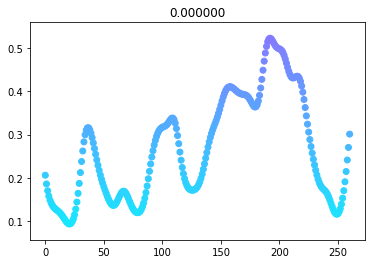

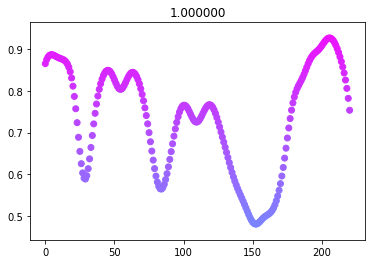

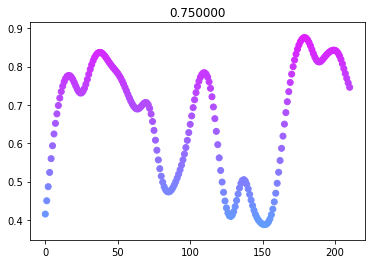

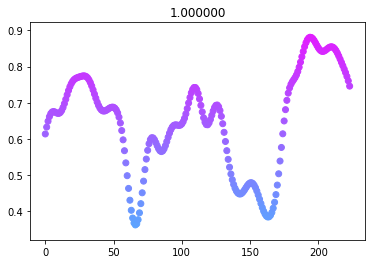

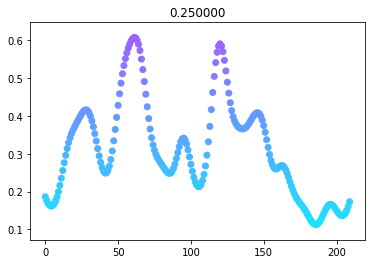

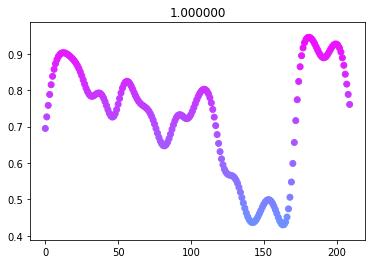

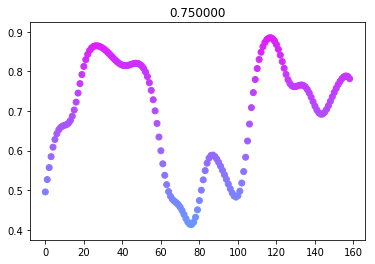

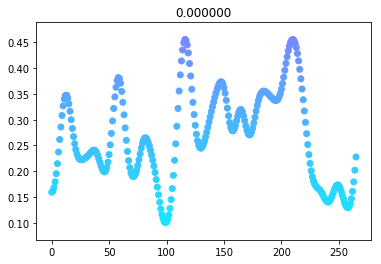

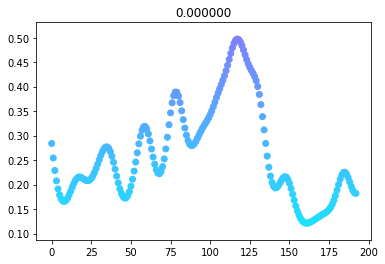

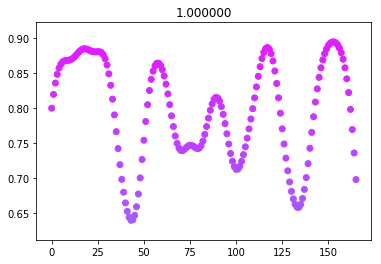

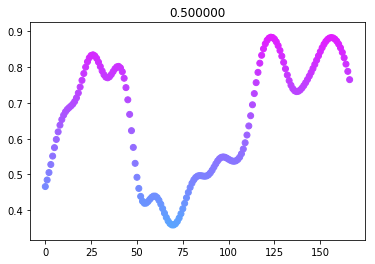

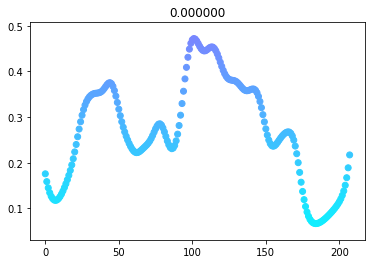

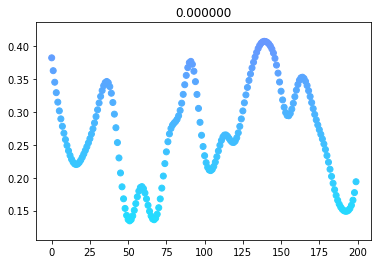

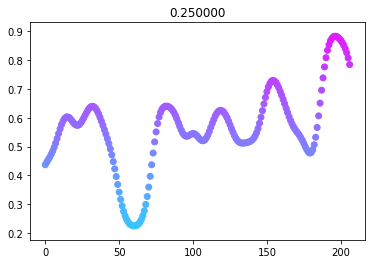

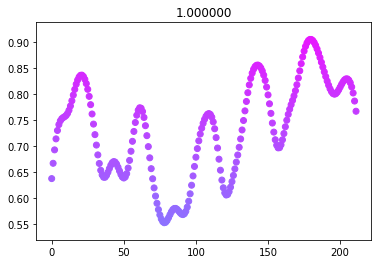

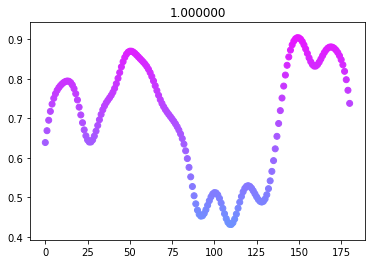

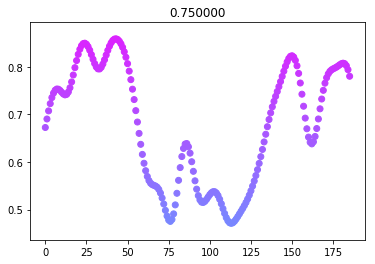

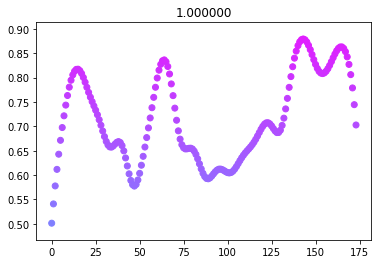

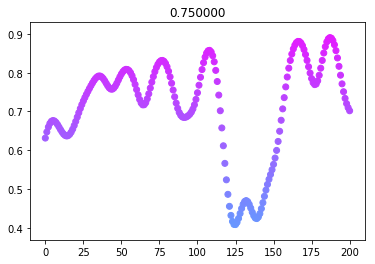

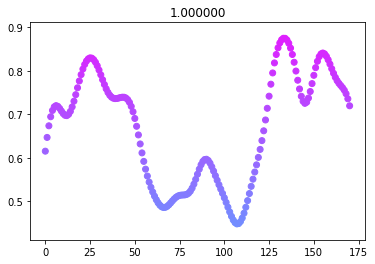

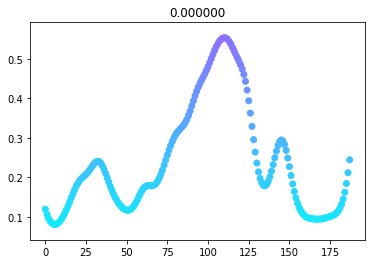

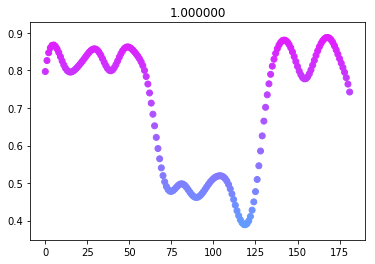

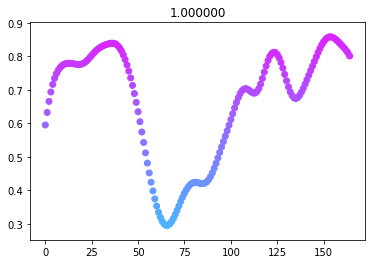

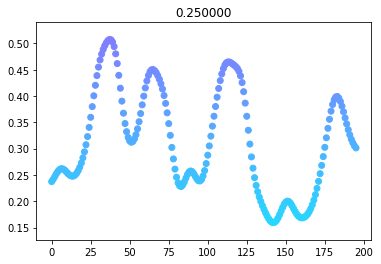

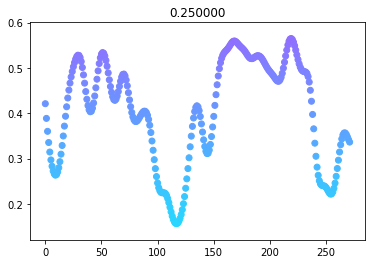

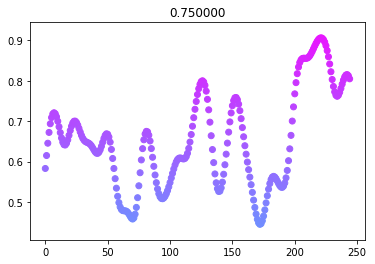

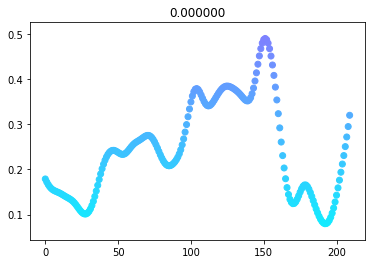

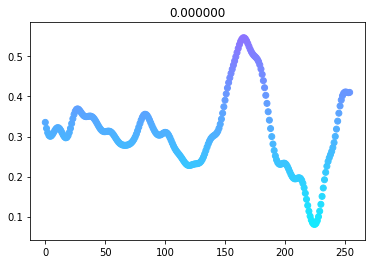

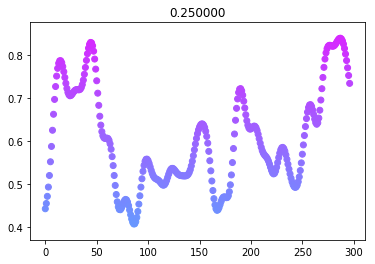

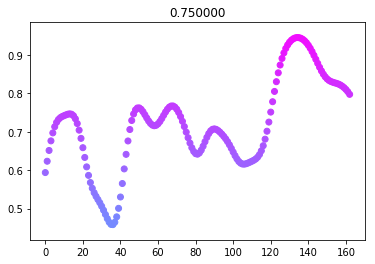

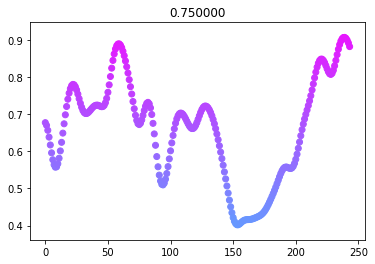

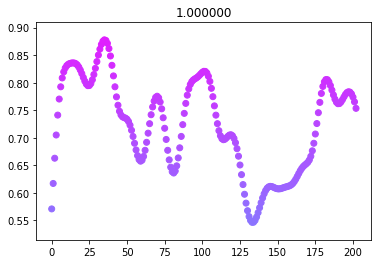

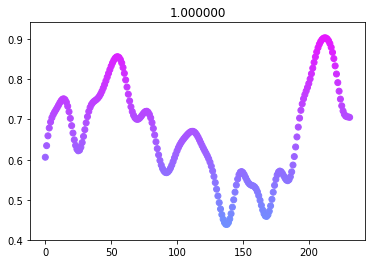

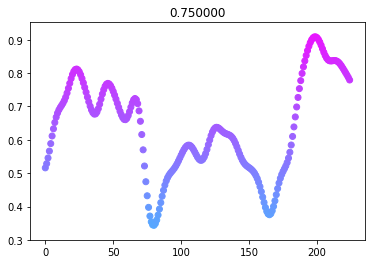

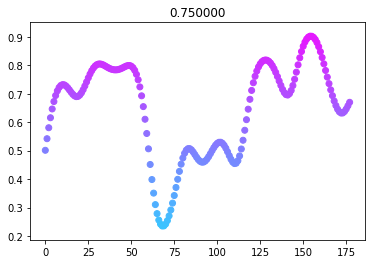

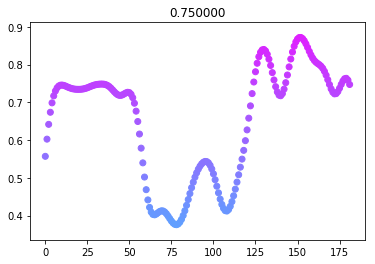

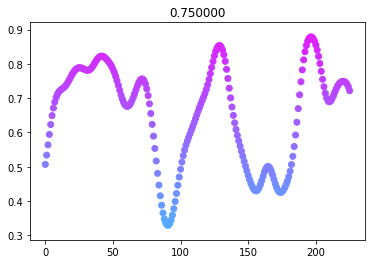

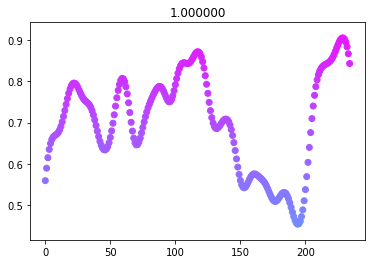

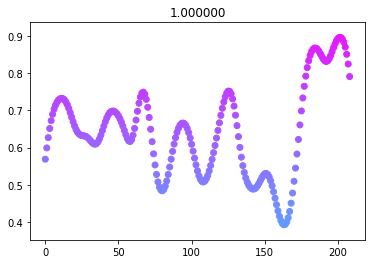

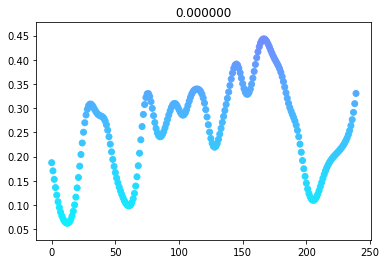

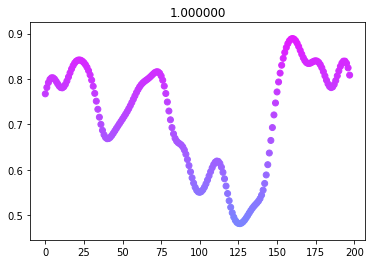

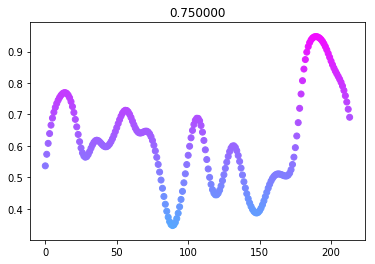

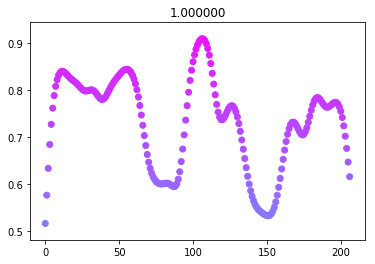

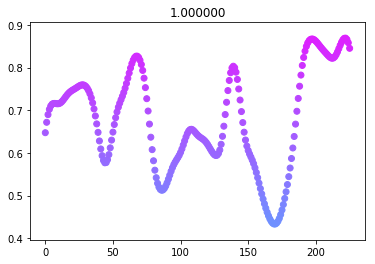

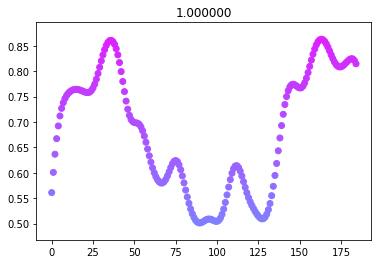

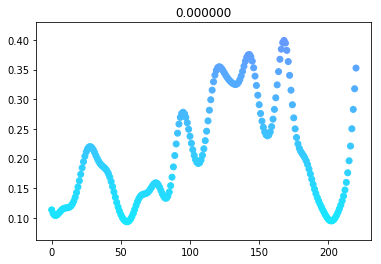

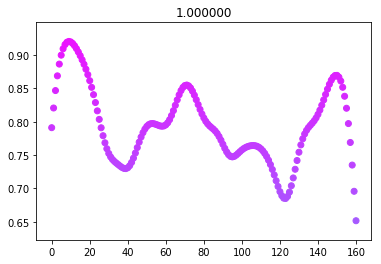

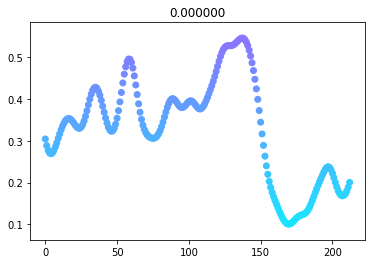

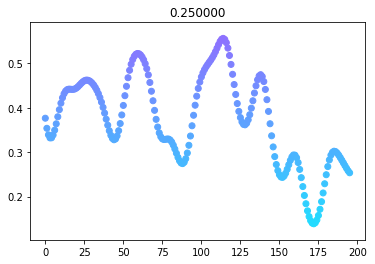

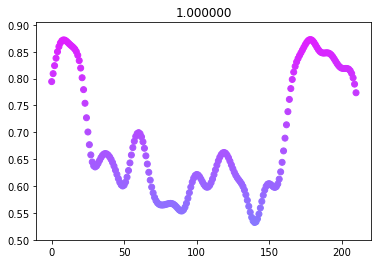

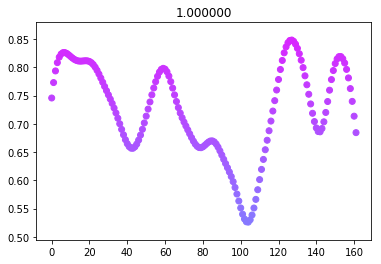

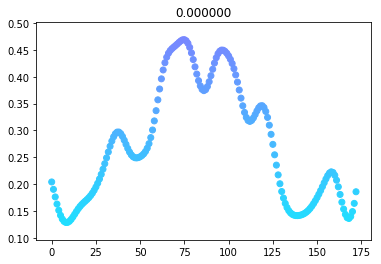

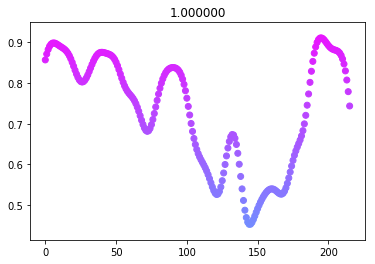

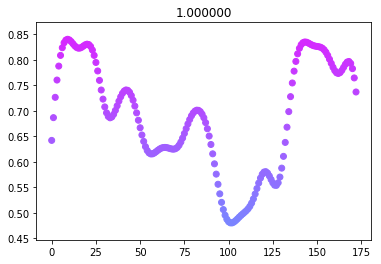

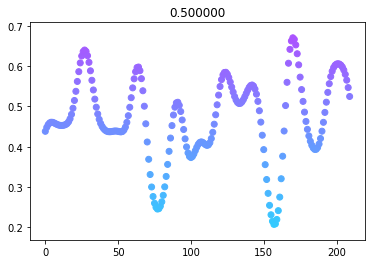

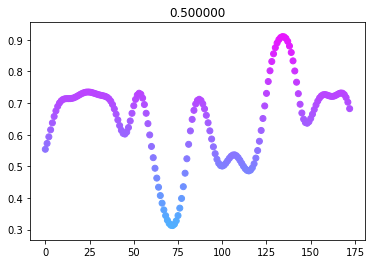

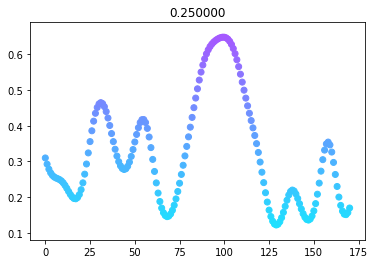

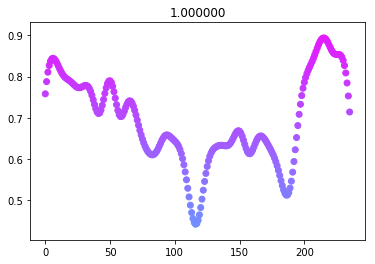

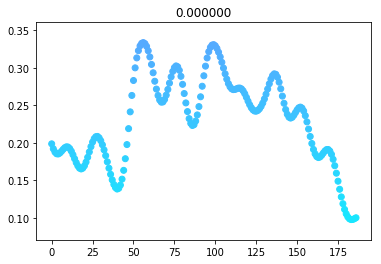

In [32]:
for i,(start,stop) in enumerate(zip(tstart_inds.tolist(),teleport_inds.tolist())):
    f,ax = plt.subplots()
#     print(np.arange(stop-1-start).shape,PROJ[start:stop-1].shape)
    ax.scatter(np.arange(stop-1-start),PROJ[start:stop-1,1],c=PROJ[start:stop-1,1],cmap='cool',vmin=0,vmax=1)
#     ax.plot(np.arange(stop-1-start),np.cumsum(PROJ[start:stop-1]))
    ax.set_title("%f" % trial_info['morphs'][i])
#     ax.set_ylim([-.5,.5])

In [33]:
ldalist = []
for ind in np.unique(pos_binned):
    # find indices for LDA
    if ind not in (0,46):
        posmask = pos_binned == ind
        morphmask = (posmask) & ((VRDat.morph._values==0) | (VRDat.morph._values==1))
        
        
       # lda = LDA()
        print(VRDat.morph._values[morphmask].shape,S[morphmask,:].shape)
        lda.fit(S[morphmask,:],VRDat.morph._values[morphmask])
        
        ldalist.append(lda)

        
    

    
    # transform LDA

(403,) (403, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(296,) (296, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(282,) (282, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(267,) (267, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(267,) (267, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(293,) (293, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(304,) (304, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(352,) (352, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(363,) (363, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(395,) (395, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(460,) (460, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(895,) (895, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(998,) (998, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(1277,) (1277, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(1202,) (1202, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(1094,) (1094, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(990,) (990, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(677,) (677, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(614,) (614, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(314,) (314, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(302,) (302, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(320,) (320, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(254,) (254, 1634)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [37]:
PROJ = np.zeros([S.shape[0],1])
for t in range(S.shape[0]):
    if pos_binned[t]>0 and pos_binned[t]<46:
        PROJ[t] = ldalist[inds[t]].predict_proba(S[t,:].reshape(1,-1))[:,1]
        


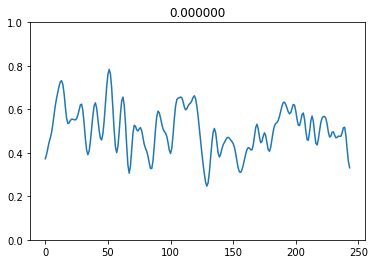

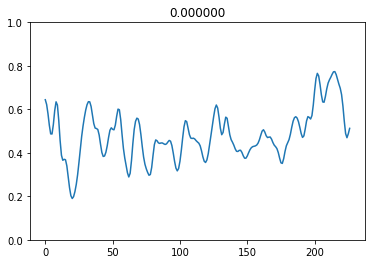

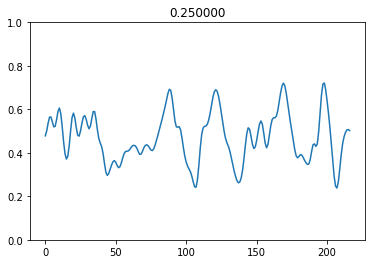

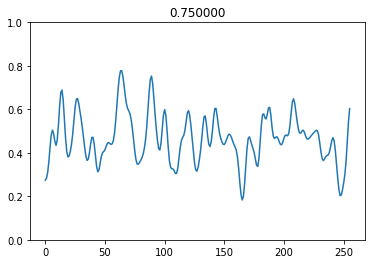

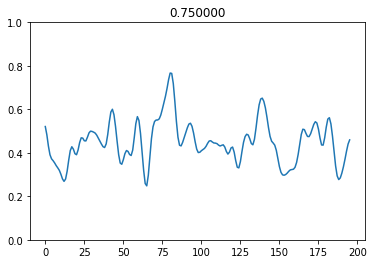

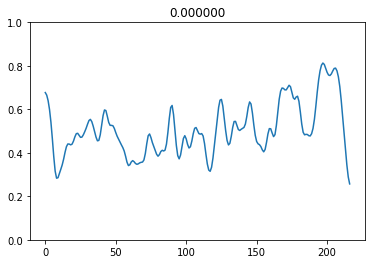

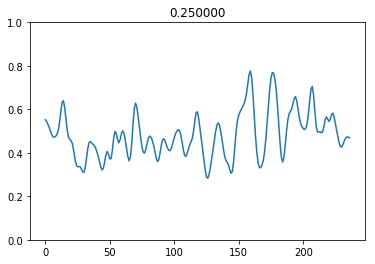

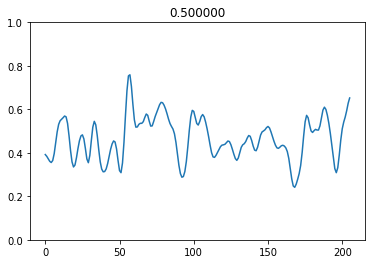

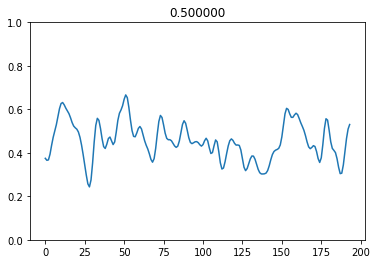

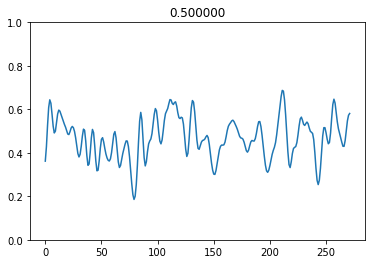

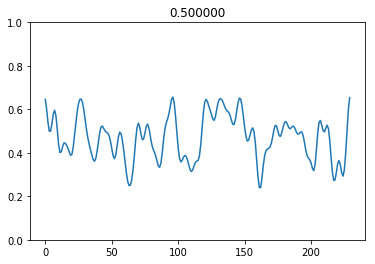

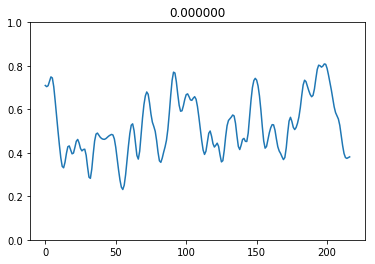

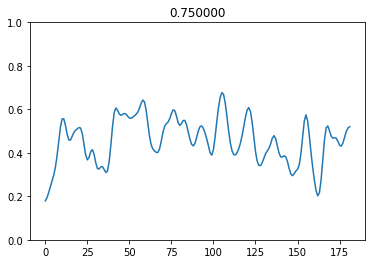

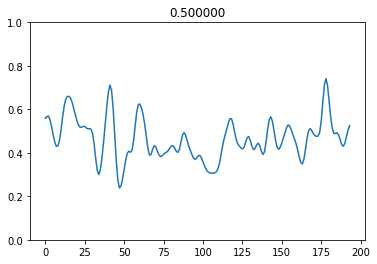

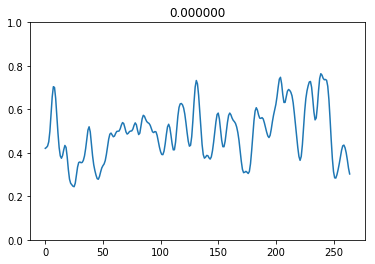

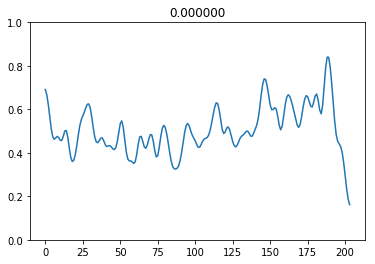

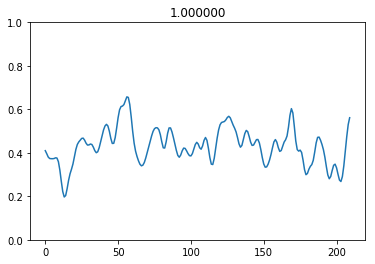

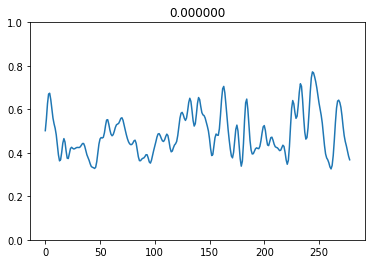

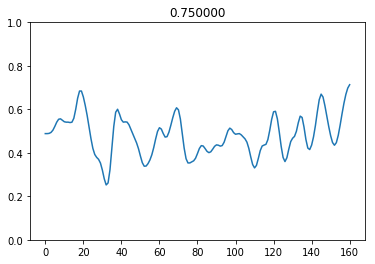

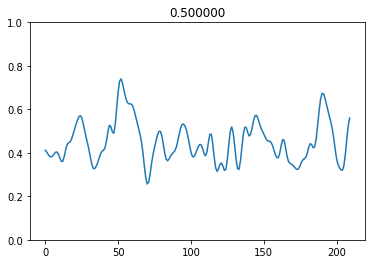

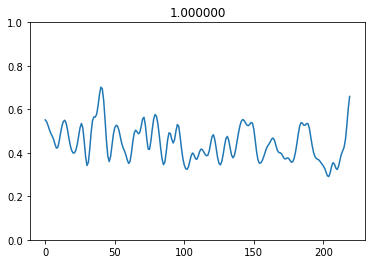

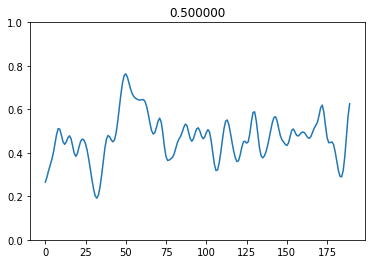

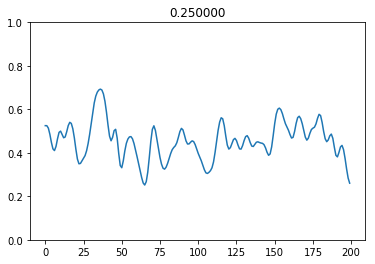

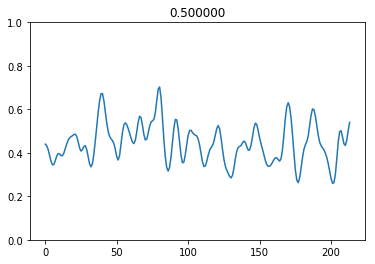

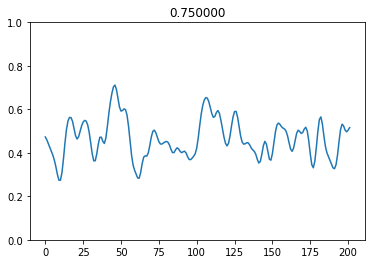

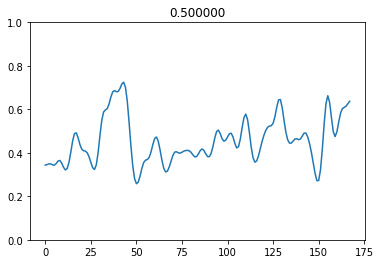

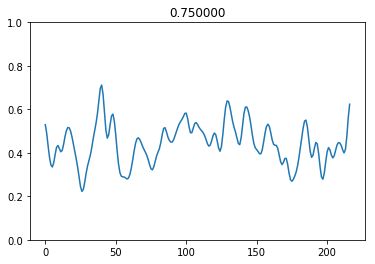

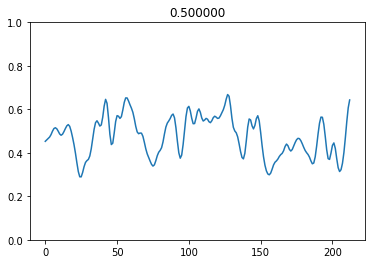

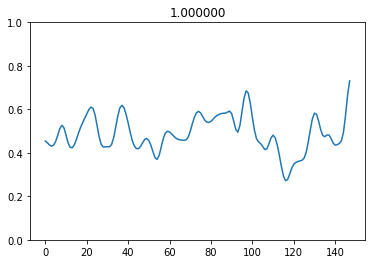

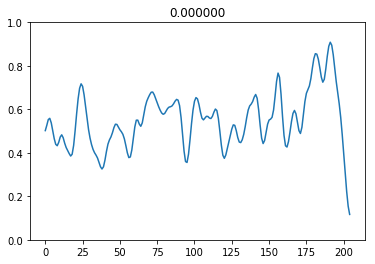

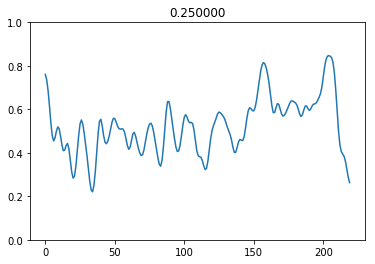

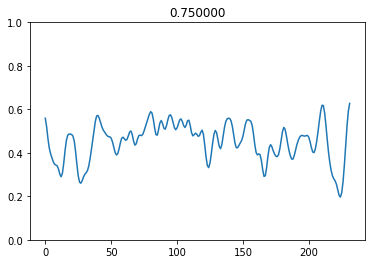

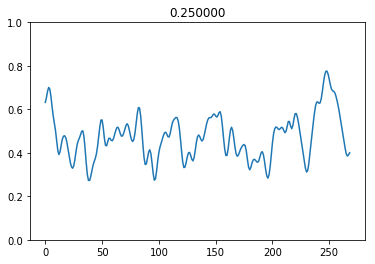

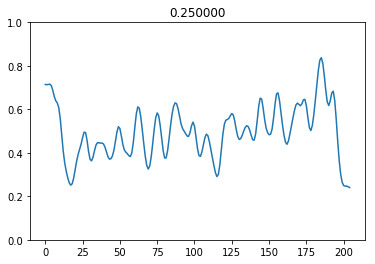

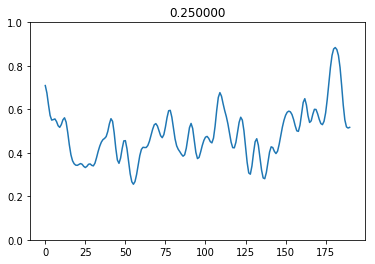

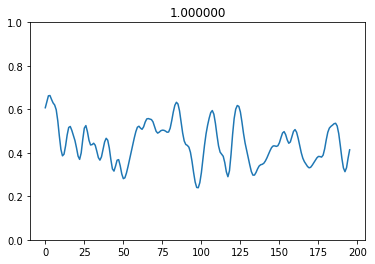

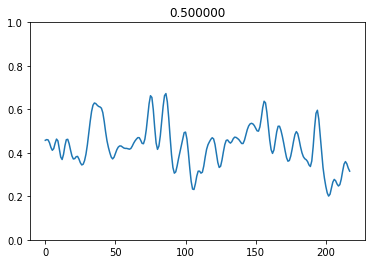

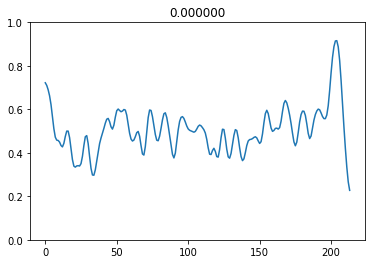

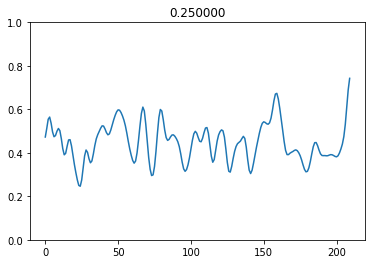

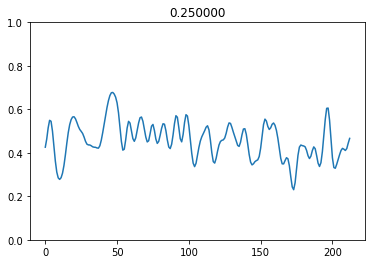

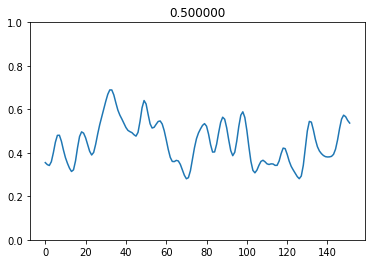

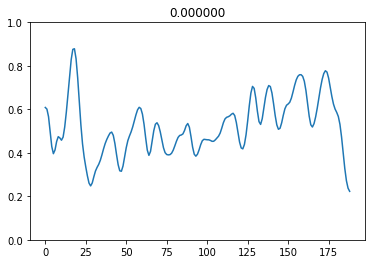

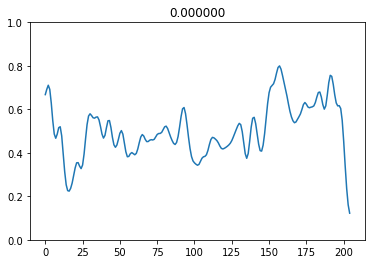

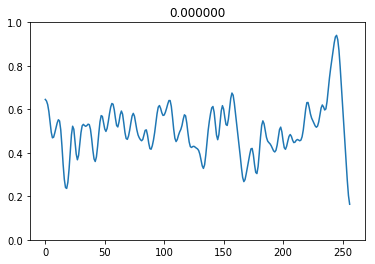

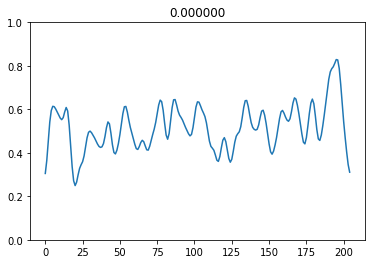

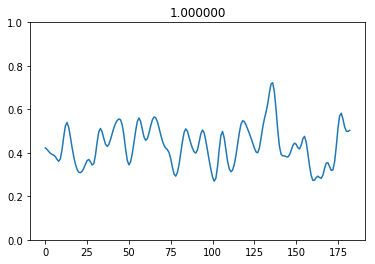

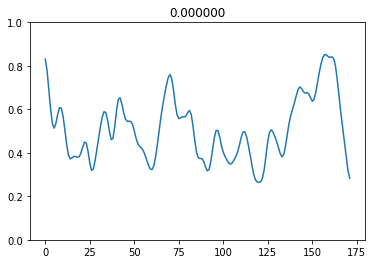

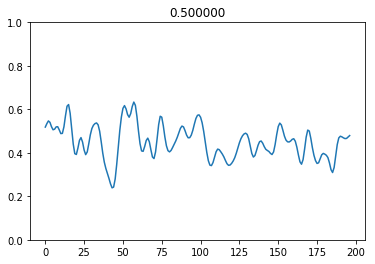

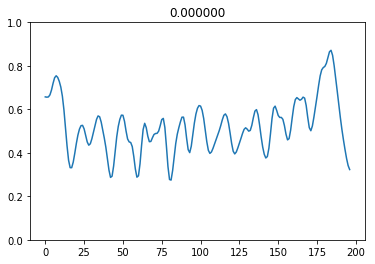

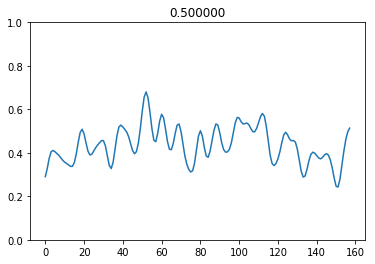

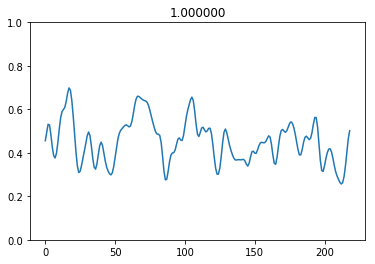

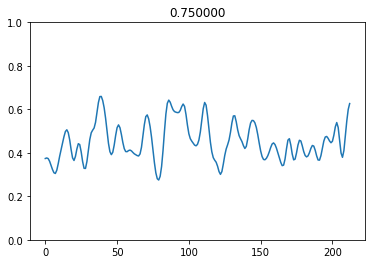

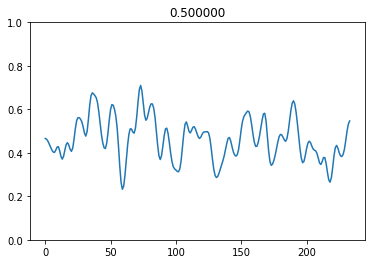

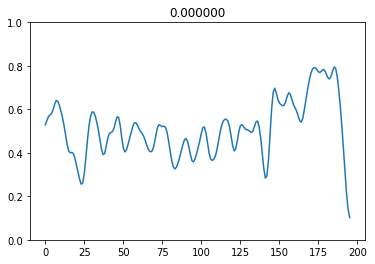

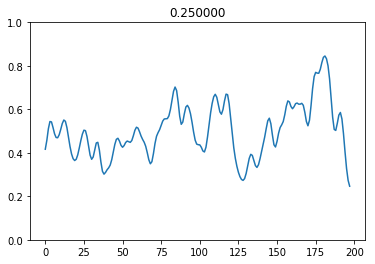

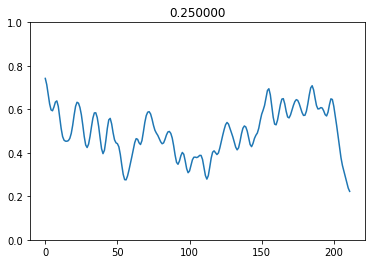

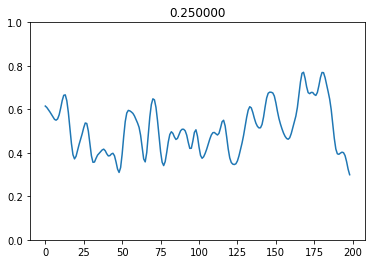

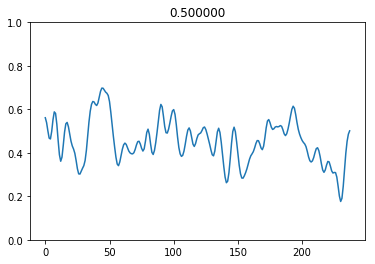

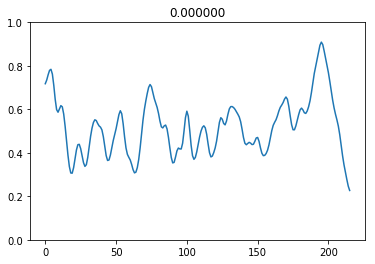

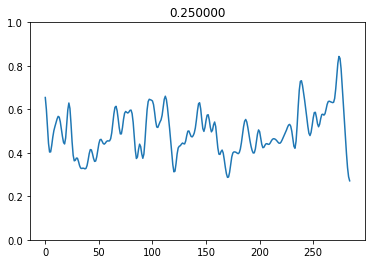

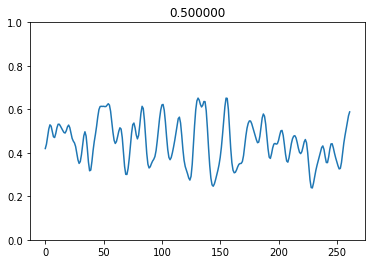

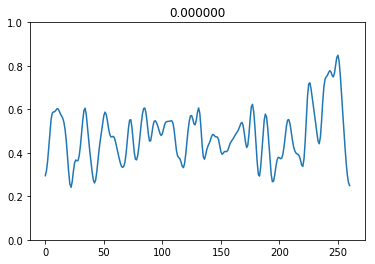

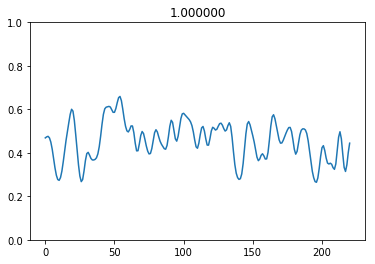

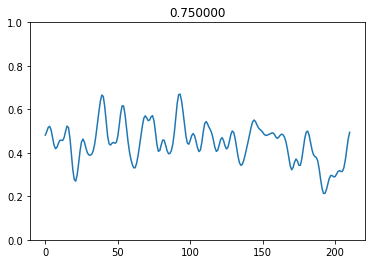

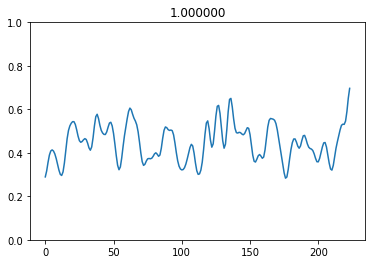

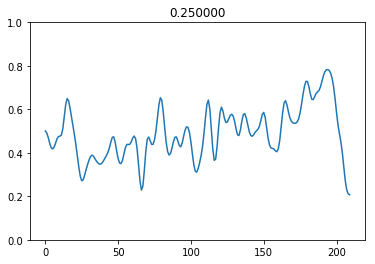

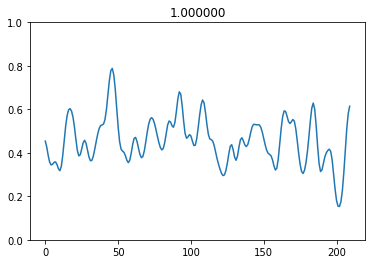

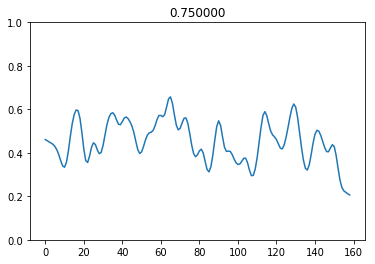

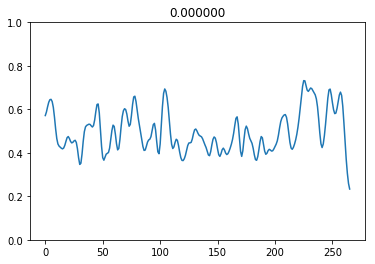

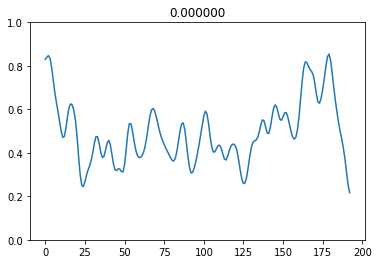

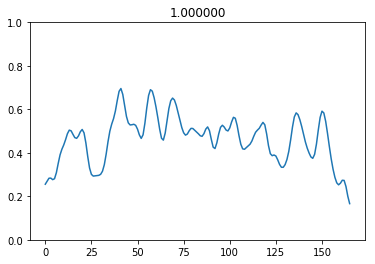

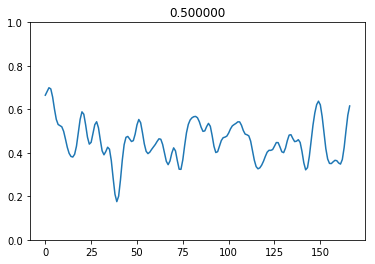

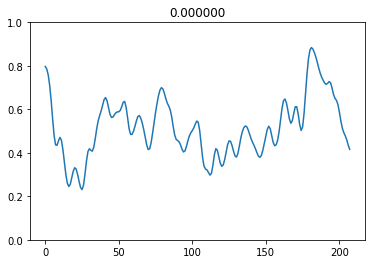

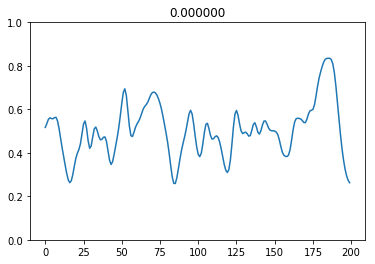

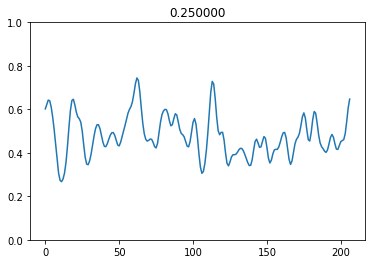

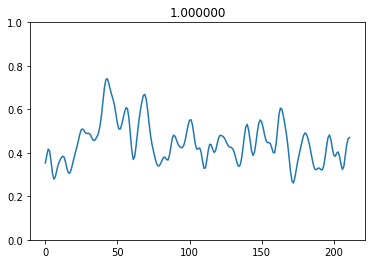

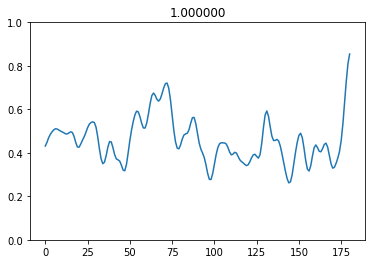

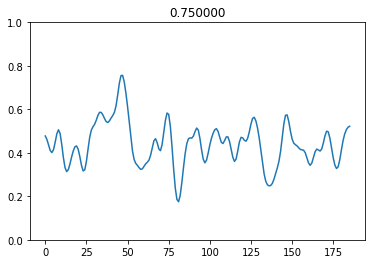

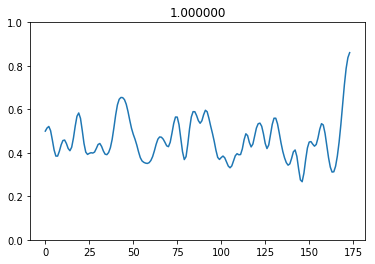

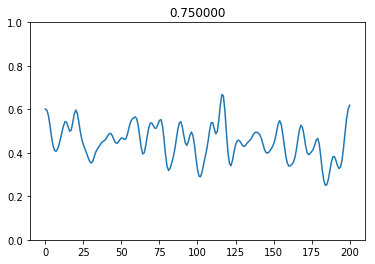

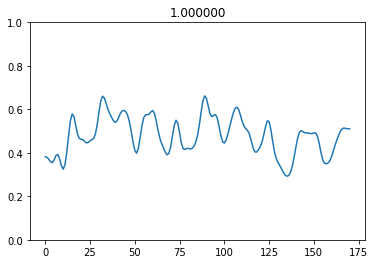

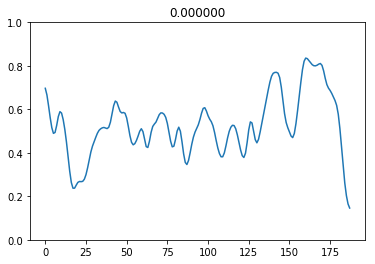

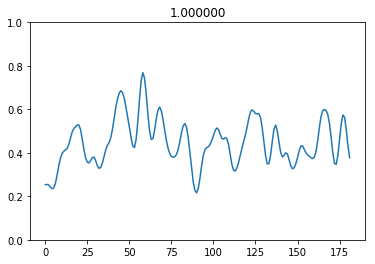

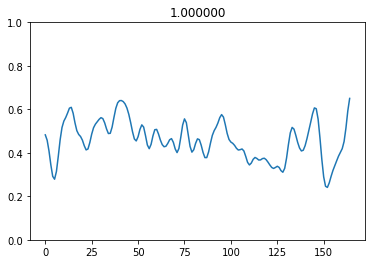

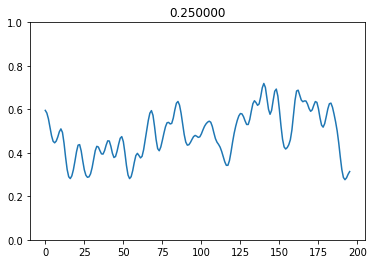

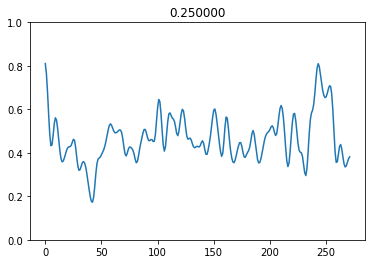

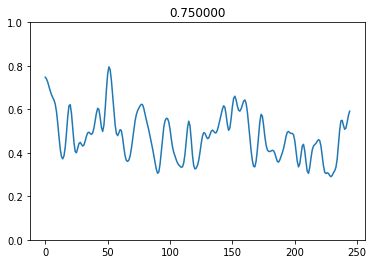

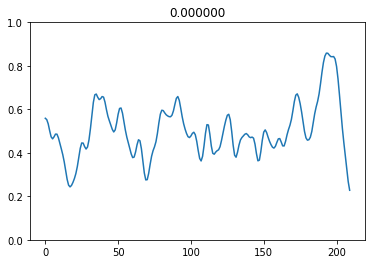

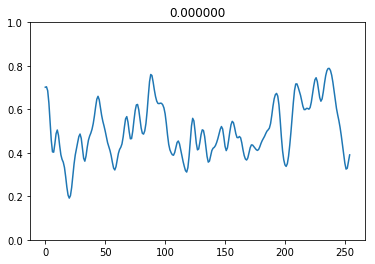

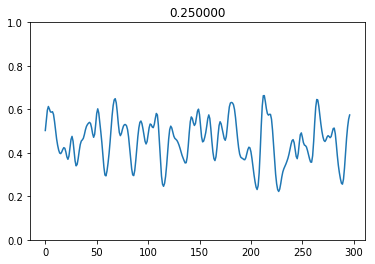

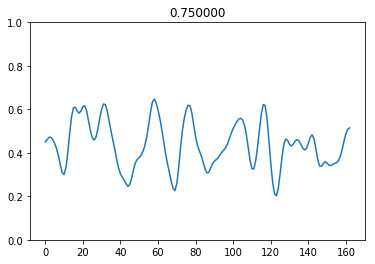

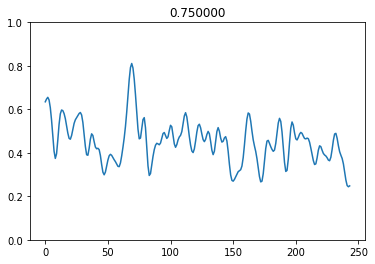

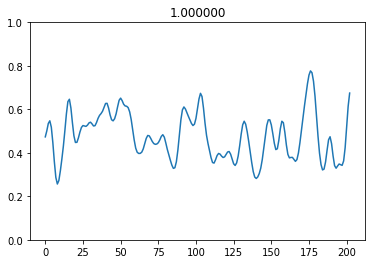

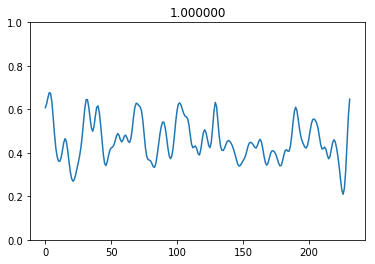

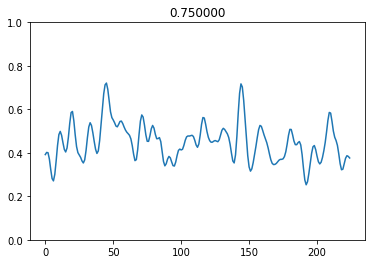

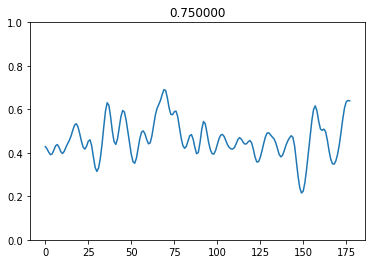

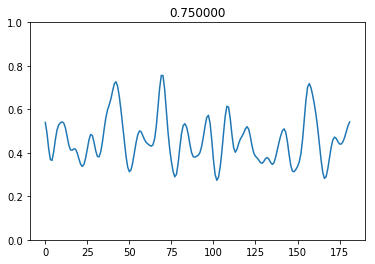

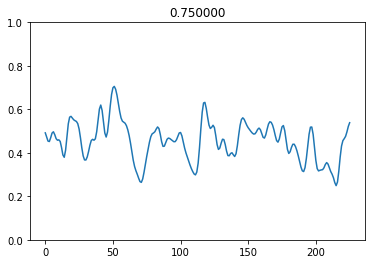

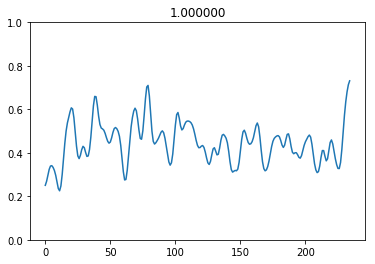

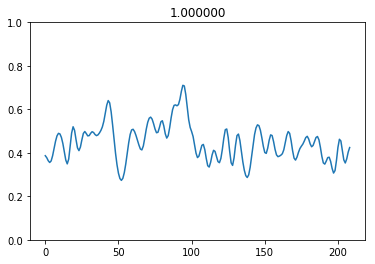

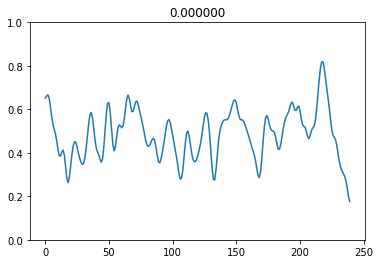

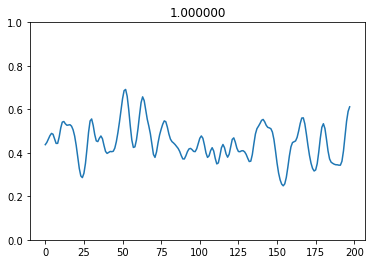

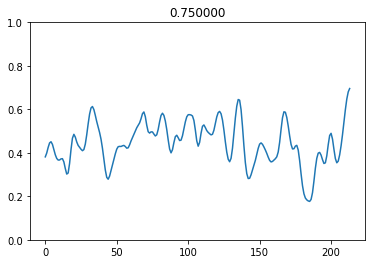

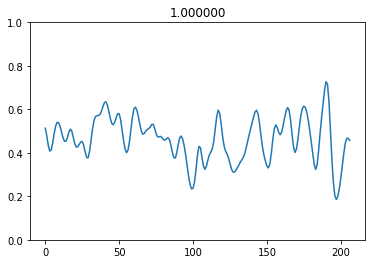

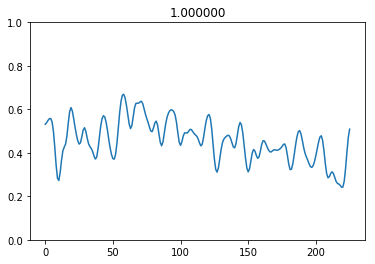

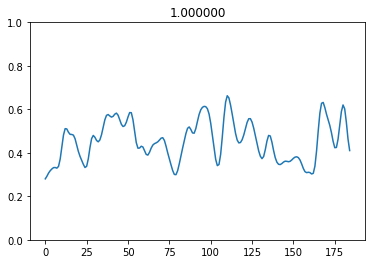

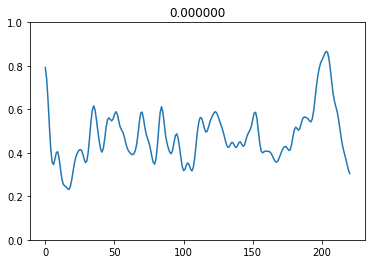

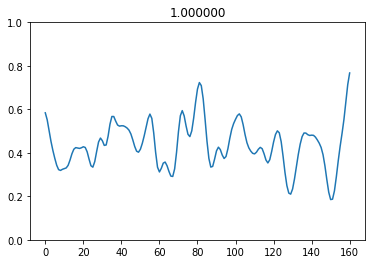

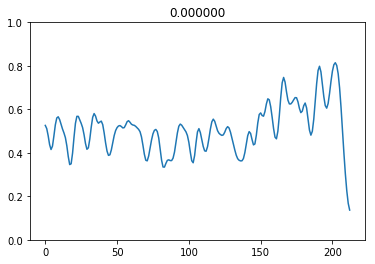

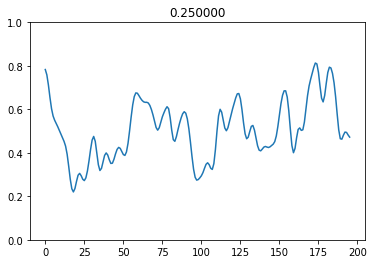

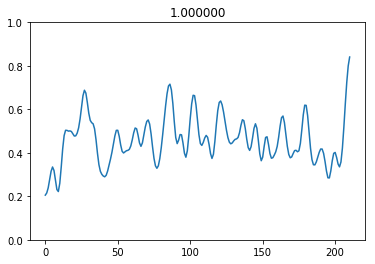

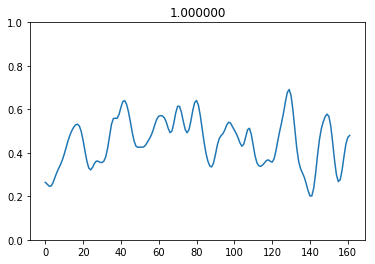

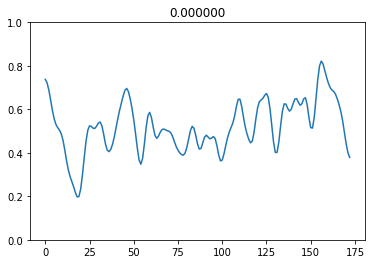

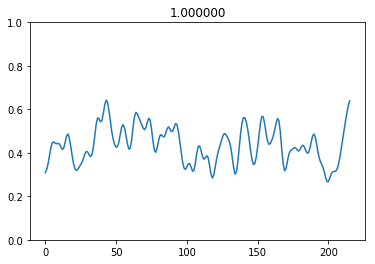

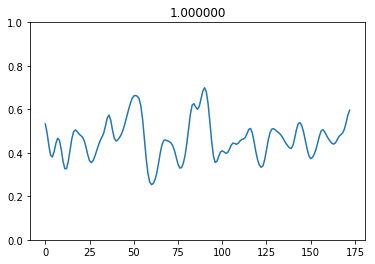

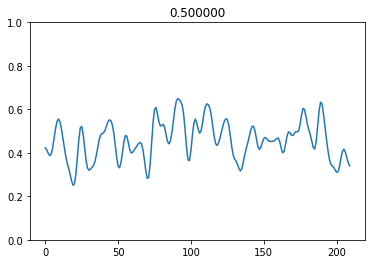

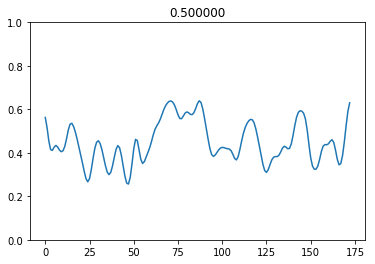

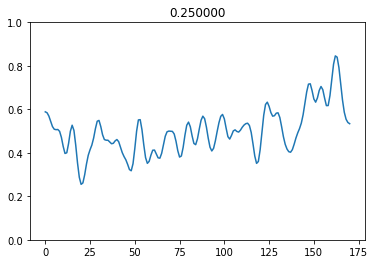

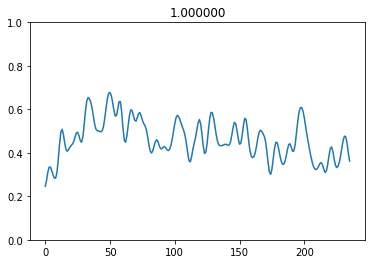

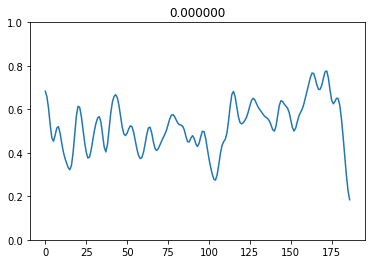

In [42]:
for i,(start,stop) in enumerate(zip(tstart_inds.tolist(),teleport_inds.tolist())):
    f,ax = plt.subplots()
    ax.plot(np.arange(stop-1-start),sp.ndimage.filters.gaussian_filter1d(PROJ[start:stop-1].ravel(),2))
#     ax.plot(np.arange(stop-1-start),np.cumsum(PROJ[start:stop-1]))
    ax.set_title("%f" % trial_info['morphs'][i])
#     ax.axhline(0,xmin=0,xmax=stop-1-start)
    ax.set_ylim([0,1])